In [1]:
import os
import time
import math
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import train_test_split
from accelerate import Accelerator, notebook_launcher
from transformers import BertTokenizer, BertModel, BertConfig
from sklearn.metrics import precision_recall_fscore_support, f1_score, classification_report

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [4]:
manager = Manager()

# Shared resources
aspect_accuracies = manager.list()
aspect_f1_micros = manager.list()
aspect_f1_macros = manager.list()
sentiment_accuracies = manager.list()
sentiment_f1_micros = manager.list()
sentiment_f1_macros = manager.list()
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()

new_sample_data = manager.list()
new_sample_labels = manager.list()

# Non shared resources
filename = 'hoasa-comal'
epochs = 10
batch_size = 16
sequence_length = 48

aspect_list = ['ac', 'air_panas', 'bau', 'general', 'kebersihan', 'linen', 'service', 'sunrise_meal', 'tv', 'wifi']
aspect_mapping = {'ac': 0, 'air_panas': 1, 'bau': 2, 'general': 3, 'kebersihan': 4, 'linen': 5, 'service': 6, 'sunrise_meal': 7, 'tv': 8, 'wifi': 9}
label_mapping = {"neg": 0, "neut": 1, 'neg_pos': 1, 'pos': 2}
ignored_keys = ['labels', 'ori_text', 'ori_label', 'ori_indices', 'aspect']

# LOAD AND PREPROCESS DATA

In [5]:
train_data = pd.read_csv('/kaggle/input/hoasa-dataset/train_preprocess.csv', encoding='latin-1')
val_data = pd.read_csv('/kaggle/input/hoasa-dataset/valid_preprocess.csv', encoding='latin-1')
test_data = pd.read_csv('/kaggle/input/hoasa-dataset/test_preprocess.csv', encoding='latin-1')

data = pd.concat([train_data, val_data, test_data], ignore_index=True)

data.head()

,review,ac,air_panas,bau,general,kebersihan,linen,service,sunrise_meal,tv,wifi
0,kebersihan kurang...,neut,neut,neut,neut,neg,neut,neut,neut,neut,neut
1,"sangat mengecewakan... hotel bad image, kebers...",neut,neut,neut,neut,neg,neut,neut,neut,neut,neut
2,Tempat nyaman bersih tapi tv terlalu tinggi ti...,neut,neut,neut,neut,pos,neut,neut,neut,neg,neut
3,"semuanya bagus sesuai profile,dan harga promo ...",neut,neg,neut,pos,neut,neut,neut,neut,neut,neut
4,"Tempat tidur sangat keras, bantal besar dan ke...",neg,neg,neut,neut,neut,neg,neut,neut,neut,neut


In [6]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

In [7]:
train_labels = train_data.columns[1:]
val_labels = val_data.columns[1:]

# Extract features and labels for training and validation
X_train = train_data['review'].values
y_train = train_data[train_labels].values
X_val = val_data['review'].values
y_val = val_data[val_labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(2283,) (2283, 10)
(571,) (571, 10)


# BULDING DATASET

In [8]:
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
review_token = '[REVIEW]'
aspect_token = '[ASPECT]'
special_tokens_dict = {'additional_special_tokens': [review_token, aspect_token]}
num_added_tokens = tokenizer.add_special_tokens(special_tokens_dict)

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [9]:
class AspectDetectionDataset(Dataset):
    def __init__(self, data, labels, tokenizer, label2id, aspect_list, max_length=48):
        # Initialize dataset with data, tokenizer, and label mappings
        self.data = data
        self.tokenizer = tokenizer
        self.label2id = label2id
        self.maxlength = sequence_length  # Maximum token length for input sequences
        self.all_labels_num = len(aspect_list)  # Total number of labels
        self.aspect_list = aspect_list
        self.pair_wise_sampled = None  # Tracks sampling status of label pairs
        self.gt_labels = labels  # Ground truth labels in one-hot format
        self.all_labeled_mask = None  # Indicates whether all labels of a sample have been queried
        self.max_length = max_length
        self.init()  # Initializes sampling and label mask states

    def init(self):
        # Initialize sampled pairs and mask for all data
        self.pair_wise_sampled = torch.ones(len(self.data), self.all_labels_num)
        self.all_labeled_mask = torch.zeros(len(self.data))  # Initially, no data is fully labeled

    def get_label_Cardinality(self):
        # Compute label cardinality, representing average positive labels per sample in the labeled pool
        labed_cnt = torch.sum(self.all_labeled_mask)  # Total number of samples fully labeled
        original_labels = torch.tensor([[self.label2id[label] for label in labels] for labels in self.gt_labels], dtype=torch.float32)
        encoded_labels = torch.tensor([[1 if label == 1 else 0 for label in labels] for labels in original_labels], dtype=torch.float32)
        all_labed_pos_label_cnt = torch.sum(self.all_labeled_mask.unsqueeze(-1) * encoded_labels)
        return all_labed_pos_label_cnt / labed_cnt  # Average number of positive labels per fully labeled sample

    def update_data(self, query_example_indices, query_label_indices=None, init_time=False):
        # Update dataset with new labeled data points and labels after each query cycle
        if query_label_indices is not None:
            ones = torch.ones(self.all_labels_num)
            for example_idx, label_idx in zip(query_example_indices, query_label_indices):
                # Access individual data and update based on queried label
                one_data = self.__getitem__(example_idx)
                one_label = one_data[1][label_idx]
                if one_label == 0:
                    # Set pair-wise sampled state for newly queried labels
                    self.pair_wise_sampled[example_idx][label_idx] = 1
                else:
                    self.pair_wise_sampled[example_idx][label_idx] = 1
                
                # Update all_labeled_mask if all labels for a sample are queried
                if torch.sum(ones - self.pair_wise_sampled[example_idx]) == 0:
                    self.all_labeled_mask[example_idx] = 1
        else:
            # Mark all labels as queried for each example if only examples are specified
            for example_idx in query_example_indices:
                ones = torch.ones(self.all_labels_num)
                self.pair_wise_sampled[example_idx] = ones
                self.all_labeled_mask[example_idx] = 1

    def get_labeled_set(self):
        # Return list of indices for samples that have been fully labeled
        labeled_set = []
        for idx, mask in enumerate(self.all_labeled_mask):
            if mask != 0:
                labeled_set.append(idx)
        return labeled_set

    def __len__(self):
        # Return the number of samples in the dataset
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data[idx] 
        original_labels = torch.tensor([self.label2id[label] for label in self.gt_labels[idx]], dtype=torch.float32)
        encoded_labels = torch.tensor([1 if label == 1 else 0 for label in original_labels], dtype=torch.float32)

        # Tokenize the raw text and apply padding/truncation to reach maxlength
        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        input_ids = encoding['input_ids'].squeeze(0)  # Remove batch dimension
        input_type_ids = encoding.get('token_type_ids', torch.zeros_like(input_ids))
        input_mask = encoding['attention_mask'].squeeze(0)
        text_inputs = [input_ids, input_type_ids, input_mask]
        sampler_loss_weight = self.pair_wise_sampled[idx]  # Weight for active learning sample 

        inputs_list = [text_inputs, encoded_labels, idx, sampler_loss_weight, self.all_labeled_mask[idx], text, original_labels]
        return inputs_list

In [10]:
class SentimentAnalysisDataset(Dataset):
    def __init__(self, data, labels, aspects, indices, tokenizer, label2id, max_length):
        # Initialize dataset with data, tokenizer, and label mappings
        self.data = data
        self.tokenizer = tokenizer
        self.label2id = label2id
        self.maxlength = sequence_length  # Maximum token length for input sequences
        self.all_labels_num = 2
        self.pair_wise_sampled = None  # Tracks sampling status of label pairs
        self.gt_labels = labels  # Ground truth labels in one-hot format
        self.all_labeled_mask = None  # Indicates whether all labels of a sample have been queried
        self.aspects = aspects
        self.indices = indices
        self.max_length = max_length
        self.init()  # Initializes sampling and label mask states

    def init(self):
        # Initialize sampled pairs and mask for all data
        self.pair_wise_sampled = torch.ones(len(self.data), self.all_labels_num)
        self.all_labeled_mask = torch.zeros(len(self.data))  # Initially, no data is fully labeled

    def get_label_Cardinality(self):
        # Compute label cardinality, representing average positive labels per sample in the labeled pool
        labed_cnt = torch.sum(self.all_labeled_mask)  # Total number of samples fully labeled
        all_labed_pos_label_cnt = torch.sum(self.all_labeled_mask.unsqueeze(-1) * self.gt_labels)
        return all_labed_pos_label_cnt / labed_cnt  # Average number of positive labels per fully labeled sample

    def update_data(self, query_example_indices, query_label_indices=None, init_time=False):
        # Update dataset with new labeled data points and labels after each query cycle
        if query_label_indices is not None:
            ones = torch.ones(self.all_labels_num)
            for example_idx, label_idx in zip(query_example_indices, query_label_indices):
                # Access individual data and update based on queried label
                one_data = self.__getitem__(example_idx)
                one_label = one_data[1][label_idx]
                if one_label == 0:
                    # Set pair-wise sampled state for newly queried labels
                    self.pair_wise_sampled[example_idx][label_idx] = 1
                else:
                    self.pair_wise_sampled[example_idx][label_idx] = 1
                
                # Update all_labeled_mask if all labels for a sample are queried
                if torch.sum(ones - self.pair_wise_sampled[example_idx]) == 0:
                    self.all_labeled_mask[example_idx] = 1
        else:
            # Mark all labels as queried for each example if only examples are specified
            for example_idx in query_example_indices:
                ones = torch.ones(self.all_labels_num)
                self.pair_wise_sampled[example_idx] = ones
                self.all_labeled_mask[example_idx] = 1

    def get_labeled_set(self):
        # Return list of indices for samples that have been fully labeled
        labeled_set = []
        for idx, mask in enumerate(self.all_labeled_mask):
            if mask != 0:
                labeled_set.append(idx)
        return labeled_set

    def __len__(self):
        # Return the number of samples in the dataset
        return len(self.data)

    def __getitem__(self, idx):
        text = aspect_token + ' ' + self.aspects[idx] + ' ' + review_token + ' ' + self.data[idx] 

        # Tokenize the raw text and apply padding/truncation to reach maxlength
        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        if isinstance(self.gt_labels[idx], str):
            self.gt_labels[idx] = self.label2id[self.gt_labels[idx]]
        elif torch.is_tensor(self.gt_labels[idx]):
            self.gt_labels[idx] = int(self.gt_labels[idx].item())

        encoded_label = 1 if self.gt_labels[idx] == 2 else self.gt_labels[idx]
        one_hot_label = F.one_hot(torch.tensor(encoded_label, dtype=torch.long), num_classes=2).float()

        input_ids = encoding['input_ids'].squeeze(0)  # Remove batch dimension
        input_type_ids = encoding.get('token_type_ids', torch.zeros_like(input_ids))
        input_mask = encoding['attention_mask'].squeeze(0)
        text_inputs = [input_ids, input_type_ids, input_mask]
        sampler_loss_weight = self.pair_wise_sampled[idx]  # Weight for active learning sample 
        original_label = torch.tensor(self.gt_labels[idx], dtype=torch.long)
        aspect = self.aspects[idx]

        inputs_list = [text_inputs, one_hot_label, idx, sampler_loss_weight, self.all_labeled_mask[idx], text, original_label, aspect, self.indices[idx]]
        return inputs_list

In [11]:
def build_aspect_dataset(X_train, y_train, X_val, y_val, sequence_length, num_workers=4):
    train_dataset = AspectDetectionDataset(X_train, y_train, tokenizer, label_mapping, aspect_list, max_length=sequence_length)
    val_dataset = AspectDetectionDataset(X_val, y_val, tokenizer, label_mapping, aspect_list, max_length=sequence_length)
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers,
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers, 
    )

    return train_loader, val_loader, train_dataset, val_dataset

In [12]:
def build_sentiment_dataset(device, train_dataset, val_dataset, aspect_detection_model, tokenizer, max_length=sequence_length):
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )

    aspect_detection_model.to(device)
    aspect_detection_model.eval()

    train_data = []
    train_labels = []
    train_aspects = []
    train_indices = []

    val_data = []
    val_labels = []
    val_aspects = []
    val_indices = []

    # Transform train set
    with torch.no_grad():
        for batch in train_loader:
            input_ids, input_type_ids, input_mask = [x.to(device) for x in batch[0]]
            inputs_list = [input_ids, input_type_ids, input_mask, None]
            
            outputs = aspect_detection_model(inputs_list)
            preds = torch.sigmoid(outputs[0]).round()

            for i in range(len(preds)):
                for j in range(len(preds[i])):
                    if int(preds[i][j]) != 1:
                        train_aspects.append(aspect_list[j])
                        train_data.append(batch[5][i])
                        train_labels.append(batch[6][i][j])
                        train_indices.append(batch[2][i])
            
        # Transform validation set
        for batch in val_loader:
            input_ids, input_type_ids, input_mask = [x.to(device) for x in batch[0]]
            inputs_list = [input_ids, input_type_ids, input_mask, None]
            
            outputs = aspect_detection_model(inputs_list)
            preds = torch.sigmoid(outputs[0]).round()

            for i in range(len(preds)):
                for j in range(len(preds[i])):
                    if int(preds[i][j]) != 1:
                        val_aspects.append(aspect_list[j])
                        val_data.append(batch[5][i])
                        val_labels.append(batch[6][i][j])
                        val_indices.append(batch[2][i])

    train_dataset = SentimentAnalysisDataset(train_data, train_labels, train_aspects, train_indices, tokenizer, label_mapping, max_length=max_length)
    val_dataset = SentimentAnalysisDataset(val_data, val_labels, val_aspects, val_indices, tokenizer, label_mapping, max_length=max_length)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4, 
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )

    return train_loader, val_loader, train_dataset, val_dataset

# DEFINE THE MODEL

In [13]:
class IndoBERT_Backbone(nn.Module):
    def __init__(self, label_num):
        super(IndoBERT_Backbone, self).__init__()
        self.label_num = label_num
        self.encoder = IndoBERT_Encoder(label_num)
        model_config = BertConfig.from_pretrained("indobenchmark/indobert-base-p1")
        self.clf = nn.Linear(model_config.hidden_size, label_num)
        nn.init.xavier_uniform_(self.clf.weight)

    def forward(self, inputs):
        encoder_out = self.encoder(inputs)
        out = self.clf(encoder_out)
        return out, encoder_out

class IndoBERT_Encoder(nn.Module):
    def __init__(self, label_num):
        super(IndoBERT_Encoder, self).__init__()
        self.label_num = label_num
        self.encoder = BertModel.from_pretrained(
            'indobenchmark/indobert-base-p1',
            num_labels=self.label_num,
        )
        
        self.encoder_init()

    def encoder_init(self):
        all_layers = ['embeddings', 'layer.0', 'layer.1', 'layer.2', 'layer.3', 'layer.4', 'layer.5', 'layer.6',
                      'layer.7', 'layer.8', 'layer.9', 'layer.10', 'layer.11', 'pooler']
        unfreeze_layers = all_layers[7:]
        for name, param in self.encoder.named_parameters():
            param.requires_grad = False
            for ele in unfreeze_layers:
                if ele in name:
                    param.requires_grad = True
                    break

    def forward(self, inputs):
        # Ensure each component in inputs is a tensor
        input_ids = torch.tensor(inputs[0]) if not isinstance(inputs[0], torch.Tensor) else inputs[0]
        token_type_ids = torch.tensor(inputs[1]) if not isinstance(inputs[1], torch.Tensor) else inputs[1]
        attention_mask = torch.tensor(inputs[2]) if not isinstance(inputs[2], torch.Tensor) else inputs[2]
        
        input_ids = input_ids.view(-1, input_ids.size(-1))  # Ensuring batch_size, sequence_length
        token_type_ids = token_type_ids.view(input_ids.size(0), -1)  # Reshaping to [batch_size, sequence_length]
        attention_mask = attention_mask.view(-1, attention_mask.size(-1))
        
        outputs = self.encoder(
            input_ids=input_ids,
            token_type_ids=token_type_ids,
            attention_mask=attention_mask,
        )
        cls_output = outputs.pooler_output
        return cls_output

In [14]:
class MLP_VAE(nn.Module):
    def __init__(self, hidden_size, device, label_num):
        super(MLP_VAE, self).__init__()
        self.device = device
        self.label_num = label_num
        self.cl_neg_mode = 1
        self.proto_size = 256
        self.hidden_size = hidden_size
        
        # Initial fully connected layer to project input to higher-dimensional space for each label
        self.fc0 = nn.Linear(self.hidden_size, self.label_num * 512)
        self.fc1 = nn.Linear(512, self.proto_size)  # Dimensionality reduction for prototypes

        # Adjust the number of label representations based on contrastive learning mode
        if self.cl_neg_mode == 0:
            cl_label_num = self.label_num  # Standard label number
        elif self.cl_neg_mode == 1:
            cl_label_num = self.label_num + 1  # Add one for negative prototype handling
            self.ins_neg_cnt = torch.zeros(1).to(device)
        elif self.cl_neg_mode == 2:
            cl_label_num = self.label_num * 2  # Double for positive and negative prototypes
            self.ins_neg_cnt = torch.zeros(self.label_num).to(device)
        self.cl_label_num = cl_label_num

        # Register buffer for label prototypes, aligned with CoMAL's prototype-based sampling
        self.register_buffer("prototypes", torch.zeros(self.cl_label_num, self.proto_size))
        self.ins_pos_cnt = torch.zeros(self.label_num).to(device)  # Track count of positive instances

        # Decoder and final aggregation layers
        self.fc3 = nn.Linear(self.proto_size, 512)
        self.agg = nn.Linear(self.label_num * 512, self.hidden_size)
        self.clf = nn.Linear(self.hidden_size, self.label_num)  # Classification layer

    def get_protos(self):
        return self.prototypes  # Return the prototypes for external use

    def reparameterize(self, mu, logvar):
        # VAE reparameterization trick for latent space sampling
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def reset_proto(self):
        # Reset prototype and count buffers
        self.ins_pos_cnt *= 0
        self.ins_neg_cnt *= 0
        self.prototypes *= 0

    def forward(self, x, labels=None, weights=None, reset_proto=False):
        # Project input into sub-representations per label
        sub_rep_ori = self.fc0(x)
        sr_shape = sub_rep_ori.shape
        sub_rep_ori = sub_rep_ori.view(sr_shape[0], self.label_num, -1)  # Split per label

        # Further reduction to prototype size and decoding step
        sub_rep = self.fc1(sub_rep_ori)
        dec_sub_rep = self.fc3(sub_rep)

        dist_1 = None
        sub_rep_norm = F.normalize(sub_rep.data, dim=-1)  # Normalize for distance calculations

        if labels is not None and weights is not None:
            # Generate masks for positive and negative samples
            pos_mask = labels * weights
            neg_mask = (1 - labels) * weights
            pos_mask = pos_mask.unsqueeze(-1)
            neg_mask = neg_mask.unsqueeze(-1)

            # Update prototypes based on positive and negative samples
            feat = torch.sum(sub_rep_norm * pos_mask, dim=0)
            self.prototypes[:self.label_num] = self.prototypes[:self.label_num] * self.ins_pos_cnt.unsqueeze(-1) + feat

            # Handle different contrastive learning modes
            if self.cl_neg_mode == 2:
                feat_neg = torch.sum(sub_rep_norm * neg_mask, dim=0)
                self.prototypes[self.label_num:] = self.prototypes[self.label_num:] * self.ins_neg_cnt.unsqueeze(-1) + feat_neg
                self.ins_neg_cnt += torch.sum(neg_mask.squeeze(-1), dim=0)
            elif self.cl_neg_mode == 1:
                feat_neg = torch.sum(sub_rep_norm * neg_mask, dim=0)
                feat_neg = torch.sum(feat_neg, dim=0)
                self.prototypes[-1] = self.prototypes[-1] * self.ins_neg_cnt + feat_neg
                self.ins_neg_cnt += torch.sum(neg_mask)
            
            # Update positive instance counts and normalize prototypes
            self.ins_pos_cnt += torch.sum(pos_mask.squeeze(-1), dim=0)
            self.prototypes = F.normalize(self.prototypes, p=2, dim=-1)

        # Calculate distances between sub-representations and prototypes
        dist_1 = sub_rep_norm @ self.prototypes.T  

        # Decode and classify reconstructed input
        concat_sub_rep = dec_sub_rep.contiguous().view(dec_sub_rep.shape[0], -1)
        recon_x = self.agg(concat_sub_rep)
        recon_x_clf = self.clf(recon_x)

        if reset_proto:
            self.reset_proto()

        return recon_x, sub_rep, recon_x_clf, dist_1  # Return reconstruction, sub-representation, classification, and distances

In [15]:
def get_cl_labels(labels, label_num, weight, cl_neg_mode=1):
    cl_labels = torch.zeros_like(labels, dtype=torch.long)
    cl_labels.fill_(label_num)
    example_idx, label_idx = torch.where(labels>=0.5)
    cl_labels[example_idx, label_idx] = label_idx #.float()
    cl_labels = cl_labels * weight + label_num * (1 - weight)
    if cl_neg_mode == 2:
        example_idx, label_idx = torch.where(labels < 0.5)
        cl_neg_labels = label_idx + label_num
        cl_labels[example_idx, label_idx] = cl_neg_labels.float()
        cl_labels = cl_labels * weight + 2 * label_num * (1 - weight)
    cl_labels = cl_labels.to(torch.int)
    return cl_labels

def get_cl_mask(cl_labels, label_num, batch_size, cl_neg_mode=1):
    mask = torch.eq(cl_labels[:batch_size], cl_labels.T).float()
    if cl_neg_mode == 0:
        neg_idx, _ = torch.where(cl_labels[:batch_size] >= label_num)
        neg_mask = torch.ones_like(mask)
        neg_mask[neg_idx] = 0
        neg_mask[:, neg_idx] = 0
        mask *= neg_mask
    elif cl_neg_mode == 1:
        neg_idx, _ = torch.where(cl_labels[:batch_size] > label_num)
        neg_mask = torch.ones_like(mask)
        neg_mask[neg_idx] = 0
        neg_mask[:, neg_idx] = 0
        mask *= neg_mask
    elif cl_neg_mode == 2:
        neg_idx, _ = torch.where(cl_labels[:batch_size] >= label_num * 2)
        neg_mask = torch.ones_like(mask)
        neg_mask[neg_idx] = 0
        neg_mask[:, neg_idx] = 0
        mask *= neg_mask
    else:
        neg_mask = torch.ones_like(mask)
    return mask, neg_mask

# DEFINE LOSSES

In [16]:
class SupConLoss(nn.Module):
    """Following Supervised Contrastive Learning:
        https://arxiv.org/pdf/2004.11362.pdf."""

    def __init__(self, temperature=0.07, base_temperature=0.07):
        super().__init__()
        self.temperature = temperature
        self.base_temperature = base_temperature

    def forward(self, features, mask, neg_mask=None, batch_size=-1, device=None, other_features=None):
        if mask is not None:
            # SupCon loss (Partial Label Mode)
            mask = mask.float().detach()
            # compute logits
            if other_features is None:
                anchor_dot_contrast = torch.div(
                    torch.matmul(features[:batch_size], features.T),
                    self.temperature)
            else:
                anchor_dot_contrast = torch.div(
                    torch.matmul(features[:batch_size], other_features.T),
                    self.temperature)

            # for numerical stability
            logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
            logits = anchor_dot_contrast - logits_max.detach()

            # mask-out self-contrast cases
            if neg_mask is None:
                logits_mask = torch.ones_like(mask)
            else:
                logits_mask = torch.scatter(
                    neg_mask,
                    1,
                    torch.arange(batch_size).view(-1, 1).to(device),
                    0
                )
            mask = mask * logits_mask

            # compute log_prob
            exp_logits = torch.exp(logits) * logits_mask
            log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True) + 1e-12)
            # compute mean of log-likelihood over positive
            mean_log_prob_pos = (mask * log_prob).sum(1) / (mask.sum(1) + 1e-12)
            # loss
            loss = - (self.temperature / self.base_temperature) * mean_log_prob_pos
            loss = loss.mean()
        else:
            q = features[:batch_size]
            k = features[batch_size:batch_size * 2]
            queue = features[batch_size * 2:]
            l_pos = torch.einsum('nc,nc->n', [q, k]).unsqueeze(-1)
            # negative logits: NxK
            l_neg = torch.einsum('nc,kc->nk', [q, queue])
            # logits: Nx(1+K)
            logits = torch.cat([l_pos, l_neg], dim=1)

            # apply temperature
            logits /= self.temperature

            # labels: positive key indicators
            labels = torch.zeros(logits.shape[0], dtype=torch.long).cuda()
            loss = F.cross_entropy(logits, labels)

        return loss

# MODEL TRAINING AND TESTING

In [17]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 50

In [18]:
def compute_metrics(p, label, classes):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    hamming_accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        labels=label,
        target_names=classes,
        zero_division=0
    ) 

    return {
        'accuracy': hamming_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [19]:
def compute_metrics_overall(p, classes):
    preds = torch.tensor(p.predictions)
    labels = torch.tensor(p.label_ids)

    # Ensure it's in the correct shape
    if preds.shape != labels.shape:
        raise ValueError("Shape mismatch: predictions and labels must have the same shape.")

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    hamming_accuracy = (preds == labels).float().mean().item()

    # Compute per-label (column-wise) precision, recall, F1
    precision_list, recall_list, f1_micro_list, f1_macro_list = [], [], [], []
    
    for i in range(labels.shape[1]):  # Loop through each column (multi-output)
        prec, rec, f1_micro, _ = precision_recall_fscore_support(
            labels[:, i], preds[:, i], average='micro', zero_division=0
        )
        _, _, f1_macro, _ = precision_recall_fscore_support(
            labels[:, i], preds[:, i], average='macro', zero_division=0
        )

        precision_list.append(prec)
        recall_list.append(rec)
        f1_micro_list.append(f1_micro)
        f1_macro_list.append(f1_macro)

    # Compute average metrics across all outputs
    precision = sum(precision_list) / len(precision_list)
    recall = sum(recall_list) / len(recall_list)
    f1_micro = sum(f1_micro_list) / len(f1_micro_list)
    f1_macro = sum(f1_macro_list) / len(f1_macro_list)

    # Generate classification report per output
    reports = [classification_report(labels[:, i], preds[:, i], target_names=classes, zero_division=0) for i in range(labels.shape[1])]

    return {
        'accuracy': hamming_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'reports': reports  # Returns list of reports, one for each output label
    }


In [20]:
def concat_test_result(outputs):
    outputs[0] = np.concatenate(outputs[0], axis=0)
    outputs[1] = np.concatenate(outputs[1], axis=0)
    outputs[2] = np.concatenate(outputs[2], axis=0)
    outputs[3] = np.concatenate(outputs[3], axis=0)
    outputs[4] = np.concatenate(outputs[4], axis=0)
    return outputs

def neaten_test_result(outputs, logits, labels, test_type):
    labels = labels.data.cpu().numpy()
    prob, pred = torch.topk(logits, 6 if test_type == 'aspect' else 2)
    prob = torch.sigmoid(prob).data.cpu().numpy()
    pred = pred.data.cpu().numpy()
    logits = torch.sigmoid(logits).data.cpu().numpy()
    pred_labels = np.zeros(logits.shape)
    pred_labels[logits >= 0.5] = 1
    outputs[0].append(labels)
    outputs[1].append(pred)
    outputs[2].append(prob)
    outputs[3].append(logits)
    outputs[4].append(pred_labels)
    
    return outputs

In [21]:
def train_total_sep2(aspect_datasets, dataloaders, trials, aspect_metrics, sentiment_metrics, metrics, current_train_size, label_num=-1, total_patience=3):
    accelerator = Accelerator(mixed_precision='fp16')
    device = accelerator.device
    accelerator.print(accelerator.distributed_type)
    
    tasks = ['aspect', 'sentiment']
    sentiment_val_loader = None

    for task in tasks:
        accelerator.print("--------------------------------------------------")
        if task == 'sentiment':
            accelerator.print("SENTIMENT ANALYSIS")
        else:
            accelerator.print("ASPECT DETECTION")
            
        accelerator.wait_for_everyone()
        best_score = {
            'accuracy': 0,
            'f1_micro': 0,
            'f1_macro': 0
        }  # Track best score for first phase
        best_score2 = {
            'accuracy': 0,
            'f1_micro': 0,
            'f1_macro': 0
        }  # Track best score for second phase
        second_phase = False  # Control flag for switching between training phases
        total_patience_cnt = 0
        models = {}

        # Initialize backbone model for task learning
        label_num = 10 if task == 'aspect' else 2
        models['backbone'] = IndoBERT_Backbone(label_num)
        optim_backbone = torch.optim.AdamW(models['backbone'].parameters(), lr=2e-5, weight_decay=0.01)

        # Initialize VAE module if specified (aligns with CoMAL's contrastive and auxiliary module)
        models['vae_module'] = MLP_VAE(768, device, label_num=label_num)
        optim_module = torch.optim.AdamW(models['vae_module'].parameters(), lr=2e-5, weight_decay=0.01)

        if task == 'sentiment':
            best_aspect_model = torch.load(f"{filename}-aspect-p1-backbone-{trials+1}.pt", weights_only=False)
            train_loader, val_loader, _, _ = build_sentiment_dataset(
                device, aspect_datasets['train'], aspect_datasets['val'], best_aspect_model, tokenizer, max_length=sequence_length
            )
            sentiment_val_loader = val_loader
            
        else:
            train_loader = dataloaders['labeled']
            val_loader = dataloaders['test']

        accelerator.wait_for_everyone()
        models['backbone'], models['vae_module'], train_loader, val_loader = accelerator.prepare(
            models['backbone'], models['vae_module'], train_loader, val_loader
        )

        # Loop over epochs
        for epoch in range(1, epochs+1):
            if second_phase:
                models['backbone'].eval()  # Backbone frozen in second phase
            else:
                models['backbone'].train()
            models['vae_module'].train()

            # Iterate over labeled data for training
            total_loss = 0
            for data in train_loader:
                # Zero the gradients for all optimizers
                optim_backbone.zero_grad()
                optim_module.zero_grad()

                # Prepare inputs and labels for training
                labels, idx, loss_weight = [x.to(device) for x in data[1:4]]
                input_ids, input_type_ids, input_mask = [x.to(device) for x in data[0]]
                inputs_list = [input_ids, input_type_ids, input_mask, None]

                loss = 0

                # Forward pass through backbone model
                clf_out, encoder_cls = models['backbone'](inputs_list)

                # VAE training logic (aligns with CoMAL's multi-label decoupling and contrastive learning)
                loss2 = 0
                module_cls = encoder_cls.detach()  # Detach to prevent gradient flow to backbone

                # Forward pass through VAE module
                recon_x, latent_rep, recon_x_clf, _ = models['vae_module'](module_cls, labels=labels, weights=loss_weight)

                # Compute contrastive loss if enabled (aligns with CoMAL's use of contrastive learning)
                cl_labels = get_cl_labels(labels, label_num, loss_weight).view(-1)
                cl_labels_total = cl_labels.unsqueeze(-1)
                proj_total = latent_rep.view(-1, latent_rep.shape[-1])
                proj_total = F.normalize(proj_total, dim=-1)  # Normalize latent representation
                batch_size = clf_out.shape[0] * label_num
                mask, neg_mask = get_cl_mask(cl_labels_total, label_num, batch_size)

                criterion_cl = SupConLoss()  # Supervised contrastive loss function
                cl_loss = criterion_cl(proj_total, mask, neg_mask, batch_size, device)
                loss2 += cl_loss  # Add contrastive loss

                # Compute reconstruction and classification loss
                criterion_mse = nn.MSELoss()
                recon_mse_loss = criterion_mse(recon_x, module_cls)
                criterion_bce = nn.BCEWithLogitsLoss(weight=loss_weight, reduction='mean')
                recon_bce_loss = criterion_bce(recon_x_clf, labels.float())
                
                loss2 += recon_mse_loss + recon_bce_loss
                
                # Compute classification loss for the backbone (first phase)
                if not second_phase:
                    criterion = nn.BCEWithLogitsLoss(weight=loss_weight, reduction='mean')
                    clf_loss = criterion(clf_out, labels.float())
                    loss += clf_loss  # Add classification loss to total loss

                # Add VAE loss to total loss
                loss += loss2
                # Backpropagation step
                accelerator.backward(loss)
                
                total_loss += loss

                # Update weights based on current phase
                if second_phase:
                    optim_module.step()
                else:
                    optim_module.step()
                    optim_backbone.step()

            # Scheduler step for learning rate adjustment
            if second_phase:
                accelerator.print('in second')
            
            result = {}
            outputs_clf = [[], [], [], [], []]
            outputs_dual = [[], [], [], [], []]
            match task:
                case 'aspect':
                    with torch.no_grad():
                        for data in val_loader:
                            input_ids, input_type_ids, input_mask = [x.to(device, non_blocking=True) for x in data[0]]
                            labels = data[1].to(device)
                            out = [input_ids, input_type_ids, input_mask, None]
                
                            clf_out, encoder_cls = models['backbone'](out)
                            outputs_clf = neaten_test_result(outputs_clf, clf_out, labels, task)

                            if 'vae_module' in models.keys():
                                _, _, recon_x_clf, _ = models['vae_module'](encoder_cls, reset_proto=True)
                                outputs_dual = neaten_test_result(outputs_dual, recon_x_clf, labels, task)

                    if second_phase:
                        outputs_dual = concat_test_result(outputs_dual)
                        preds = torch.tensor(outputs_dual[4], device=device)
                        labels = torch.tensor(outputs_dual[0], device=device)
                    else:
                        outputs_clf = concat_test_result(outputs_clf)
                        preds = torch.tensor(outputs_clf[4], device=device)
                        labels = torch.tensor(outputs_clf[0], device=device)

                    preds = accelerator.gather_for_metrics(preds)
                    labels = accelerator.gather_for_metrics(labels)
                        
                    result = compute_metrics(
                        type('EvalOutput', (object,), {'predictions': preds.cpu().numpy(), 'label_ids': labels.cpu().numpy()}),
                        None,
                        aspect_list,
                    )
                case 'sentiment':
                    sentiment_val_outputs = []
                    with torch.no_grad():
                        for data in val_loader:
                            input_ids, input_type_ids, input_mask = [x.to(device, non_blocking=True) for x in data[0]]
                            labels = data[1].to(device)
                            out = [input_ids, input_type_ids, input_mask, None]
                        
                            clf_out, encoder_cls = models['backbone'](out)
                            clf_out = torch.sigmoid(clf_out)
                        
                            if 'vae_module' in models.keys():
                                _, _, recon_x_clf, _ = models['vae_module'](encoder_cls, reset_proto=True)
                                recon_x_clf = torch.sigmoid(recon_x_clf)

                            for i in range(len(clf_out)):
                                val_output = {
                                    'label': data[1][i],
                                    'aspect': data[7][i],
                                    'ori_indices': data[2][i],
                                    'pred': np.argmax(clf_out[i].cpu().numpy() if not second_phase else recon_x_clf[i].cpu().numpy()),
                                }
                                sentiment_val_outputs.append(val_output)

                    sentiment_val_outputs = accelerator.gather_for_metrics(sentiment_val_outputs)
                    unique_val_outputs = {(x['ori_indices'].item(), x['aspect']): x for x in sentiment_val_outputs}
                    sentiment_val_outputs = list(unique_val_outputs.values())

                    result = compute_metrics(
                        type('EvalOutput', (object,), {'predictions': [item['pred'] for item in sentiment_val_outputs], 'label_ids': [np.argmax(item['label'].cpu().numpy()) for item in sentiment_val_outputs]}),
                        [0, 1],
                        ['negative', 'positive']
                    )

            if second_phase:
                if result["f1_micro"] >= best_score2['f1_micro']:
                    total_patience_cnt = 0
                    best_score2 = result
                    
                    accelerator.wait_for_everyone()
                    unwrapped_vae = accelerator.unwrap_model(models['vae_module'])
                    if accelerator.is_local_main_process:
                        accelerator.save(unwrapped_vae, f"{filename}-{task}-p2-vae-{trials+1}.pt")
                else:
                    total_patience_cnt += 1
                    if total_patience_cnt >= total_patience:
                        break
            else:
                if result["f1_micro"] >= best_score['f1_micro']:
                    best_score = result
                    total_patience_cnt = 0

                    accelerator.wait_for_everyone()
                    unwrapped_backbone = accelerator.unwrap_model(models['backbone'])
                    unwrapped_vae = accelerator.unwrap_model(models['vae_module'])

                    if accelerator.is_local_main_process:
                        accelerator.save(unwrapped_backbone, f"{filename}-{task}-p1-backbone-{trials+1}.pt")
                        accelerator.save(unwrapped_vae, f"{filename}-{task}-p1-vae-{trials+1}.pt")
                else:
                    total_patience_cnt += 1
                    if total_patience_cnt >= total_patience:
                        total_patience_cnt = 0
                        second_phase = True
                
            accelerator.print(f"EPOCH {epoch} | LOSS: {total_loss / len(dataloaders['labeled'])} | ACCURACY: {round(result['accuracy'], 4)} | F1 MACRO: {round(result['f1_macro'], 4)} | F1 MICRO: {round(result['f1_micro'], 4)}")

        if accelerator.is_local_main_process:
            if task == 'aspect':
                aspect_metrics[0].append(best_score['accuracy'])
                aspect_metrics[1].append(best_score['f1_micro'])
                aspect_metrics[2].append(best_score['f1_macro'])
            elif task == 'sentiment':
                sentiment_metrics[0].append(best_score['accuracy'])
                sentiment_metrics[1].append(best_score['f1_micro'])
                sentiment_metrics[2].append(best_score['f1_macro'])
        
        accelerator.print(f"{task}: ACCURACY {round(best_score['accuracy'], 4)} | F1 MACRO {round(best_score['f1_macro'], 4)} | F1 MICRO {round(best_score['f1_micro'], 4)}")
        accelerator.print(best_score['report'])

    # Compute overall metrics
    aspect_labels = []
    aspect_indices = []
    aspect_preds = []

    aspect_outputs = {}
    sentiment_outputs = []

    accelerator.wait_for_everyone()
    
    best_aspect_model = torch.load(f"{filename}-aspect-p1-backbone-{trials+1}.pt", weights_only=False)
    best_sentiment_model = torch.load(f"{filename}-sentiment-p1-backbone-{trials+1}.pt", weights_only=False)

    best_aspect_model, best_sentiment_model, val_loader = accelerator.prepare(best_aspect_model, best_sentiment_model, dataloaders['test'])

    with torch.no_grad():
        for batch in val_loader:
            input_ids, input_type_ids, input_mask = [x.to(device) for x in batch[0]]
            inputs_list = [input_ids, input_type_ids, input_mask, None]
            clf_out, encoder_cls = best_aspect_model(inputs_list)
            preds = torch.sigmoid(clf_out).round()

            aspect_indices.append(accelerator.gather(batch[2]))
            aspect_labels.append(accelerator.gather(batch[6]))
            aspect_preds.append(accelerator.gather(preds))

        aspect_indices = torch.cat(aspect_indices).cpu().numpy()
        aspect_labels = torch.cat(aspect_labels).cpu().numpy()
        aspect_preds = torch.cat(aspect_preds).cpu().numpy()

        accelerator.wait_for_everyone()
        aspect_outputs = [
            {'ori_indices': aspect_indices[i], 
             'ori_labels': aspect_labels[i], 
             'pred': aspect_preds[i]}
            for i in range(len(aspect_preds))
        ]
        aspect_outputs = {x['ori_indices'].item(): x for x in aspect_outputs}
    
        for batch in sentiment_val_loader:
            input_ids, input_type_ids, input_mask = [x.to(device) for x in batch[0]]
            inputs_list = [input_ids, input_type_ids, input_mask, None]
            clf_out, encoder_cls = best_sentiment_model(inputs_list)
            preds = torch.sigmoid(clf_out).round()
    
            for i in range(len(preds)):
                output = {
                    'aspect': batch[7][i],
                    'ori_indices': batch[8][i],
                    'pred': np.argmax(preds[i].cpu().numpy()),
                }
                sentiment_outputs.append(output)

        sentiment_outputs = accelerator.gather_for_metrics(sentiment_outputs)
        sentiment_outputs = {(x['ori_indices'].item(), x['aspect']): x for x in sentiment_outputs}

    # Replcae non neutral aspect to its predicted sentiment
    accelerator.wait_for_everyone()
    if accelerator.is_main_process:
        i = -1
        for (ori_index, aspect), value in sentiment_outputs.items():
            aspect = aspect_mapping[aspect]
            aspect_outputs[ori_index]['pred'][aspect] = 2 if value['pred'] == 1.0 else value['pred']

        result = compute_metrics_overall(
            type('EvalOutput', (object,), {'predictions': [output['pred'] for output in aspect_outputs.values()], 'label_ids': [output['ori_labels'] for output in aspect_outputs.values()]}),
            ['negative', 'neutral', 'positive'],
        )

        accelerator.print("--------------------------------------------------")
        accelerator.print(f"Iteration {current_train_size}: Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")
        accelerator.print("--------------------------------------------------")
        
        for i in range(len(train_labels)):
            accelerator.print(f"Aspect {aspect_list[i]} report:")
            accelerator.print(result['reports'][i])
            
        metrics[0].append(current_train_size)
        metrics[1].append(result['accuracy'])
        metrics[2].append(result['f1_micro'])
        metrics[3].append(result['f1_macro'])

# QUERY STRATEGY

In [22]:
def query_samples(filename, dataset, labeled_set, unlabeled_indices, num_labels, trials, sampling_dur, new_sample_data, new_sample_labels,
                  label_cardinality=None, labeled_subset=None, save_path=None, cl_neg_mode=1, n_samples=min_increment):
    accelerator = Accelerator(mixed_precision='fp16')
    device = accelerator.device

    models = {}
    tasks = ['aspect', 'sentiment']

    for task in tasks:
        models[f'{task}_backbone'] = torch.load(f"{filename}-{task}-p1-backbone-{trials+1}.pt")
        if os.path.exists(f'/kaggle/working/{filename}-{task}-p2-vae-{trials+1}.pt'):
            models[f'{task}_vae_module'] = torch.load(f"{filename}-{task}-p2-vae-{trials+1}.pt")
        else:
            models[f'{task}_vae_module'] = torch.load(f"{filename}-{task}-p1-vae-{trials+1}.pt")

    current_train_size = len(dataset.get_labeled_set())
    
    # Set all models to evaluation mode to freeze parameters during sampling
    for model_name in models.keys():
        models[model_name].to(device)
        models[model_name].eval()

    # Initialize lists to store outputs used for sampling calculations
    aspect_outputs = {}
    sentiment_outputs = {}
    
    labeled_distances = []
    labeled_ground_truths = []
    
    labeled_aspects = []
    labeled_labels = []
    labeled_indices = []
    labeled_texts = []

    unlabeled_aspects = []
    unlabeled_labels = []
    unlabeled_ori_indices = []
    unlabeled_texts = []

    # DataLoader for labeled data subset, sampled randomly
    labeled_dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        shuffle=False,
        pin_memory=True,
        sampler=SubsetRandomSampler(list(set(labeled_set)))
    )

    start_time = time.time()

    # Process labeled data to extract features and distances for sampling criteria
    for batch in labeled_dataloader:
        text_inputs = batch[0]
        gt_label = batch[1]
        idx = batch[2]
        input_ids, token_type_ids, attention_mask = [x.to(device, non_blocking=True) for x in text_inputs]
        labeled_ground_truths.extend(gt_label)

        with torch.no_grad():
            # Use backbone model to get encoded representations
            predictions, encoded_cls = models['aspect_backbone']([input_ids, token_type_ids, attention_mask, None])

            for i in range(len(predictions)):
                indices = idx[i].item()
                for j in range(len(predictions[i])):
                    if int(predictions[i][j].round()) != 1:
                        labeled_aspects.append(aspect_list[j])
                        labeled_labels.append(gt_label[i][j])
                        labeled_texts.append(batch[5][i])
                        labeled_indices.append(indices)
                    
            _, sub_representation, _, vae_distance = models['aspect_vae_module'](encoded_cls)
            vae_distance = vae_distance.cpu().data
            labeled_distances.extend(vae_distance)

    # Stack outputs for further processing
    labeled_ground_truths = torch.stack(labeled_ground_truths)
    labeled_distances = torch.stack(labeled_distances)

    accelerator.wait_for_everyone()
    if accelerator.is_main_process:
        # Compute self-prototype distances based on CoMAL's contrastive learning mode
        if cl_neg_mode == 1:
            labeled_prototype_distances = labeled_distances[:, :, :-1]  # Exclude last distance for prototype calculation
            labeled_prototype_distances = labeled_prototype_distances * torch.eye(num_labels)  # Keep only diagonal elements
            labeled_prototype_distances = torch.sum(labeled_prototype_distances, dim=-1)  # Sum along prototype axis
            positive_distances = labeled_prototype_distances * labeled_ground_truths  # Mask with ground truth labels
    
        # Calculate max, min, and mean positive distances for uncertainty measurement
        max_positive_distances = torch.max(positive_distances, dim=0)[0]
        min_positive_distances = torch.min(positive_distances + (1 - labeled_ground_truths) * 2, dim=0)[0]
        mean_positive_distances = (max_positive_distances + min_positive_distances) / 2
    
        # DataLoader for unlabeled data to compute sampling scores
        unlabeled_dataloader = DataLoader(
            dataset,
            batch_size=batch_size,
            num_workers=4,
            shuffle=False,
            pin_memory=True,
            sampler=SubsetRandomSampler(list(set(unlabeled_indices)))
        )
    
        # Process unlabeled data to get sampling scores
        for batch in unlabeled_dataloader:
            text_inputs = batch[0]
            labels = batch[1]
            idx = batch[2]
            loss_weight = batch[3]
            input_ids, token_type_ids, attention_mask = [x.to(device) for x in text_inputs]
    
            with torch.no_grad():
                # Get predictions and encoded representations
                predictions, encoded_cls = models['aspect_backbone']([input_ids, token_type_ids, attention_mask, None])
                predictions = predictions.cpu().data
                
                for i in range(len(predictions)):
                    indices = idx[i].item()
                    
                    if indices not in aspect_outputs.keys():
                        aspect_outputs[indices] = {}
                        
                    aspect_outputs[indices]['backbone_predictions'] = predictions[i]
                    aspect_outputs[indices]['loss_weight'] = loss_weight[i]
                    
                    # Collect non neutral aspect for sentiment analysis
                    for j in range(len(predictions[i])):
                        if int(torch.sigmoid(predictions[i][j]).round()) != 1:
                            unlabeled_aspects.append(aspect_list[j])
                            unlabeled_labels.append(labels[i][j])
                            unlabeled_texts.append(batch[5][i])
                            unlabeled_ori_indices.append(indices)
    
                # Get latent representations, reconstructions, and distances
                _, _, _, vae_distance = models['aspect_vae_module'](encoded_cls)

                for i in range(len(vae_distance)):
                    aspect_outputs[idx[i].item()]['backbone_distances'] = vae_distance[i].cpu().data

        # Convert lists to tensors for further computation
        sample_indices = torch.stack([torch.tensor(key, dtype=torch.long) for key in aspect_outputs.keys()])
        sample_weights = torch.stack([aspect_outputs[key]['loss_weight'] for key in aspect_outputs.keys()])
        distance_matrix = torch.stack([aspect_outputs[key]['backbone_distances'] for key in aspect_outputs.keys()])
    
        # Convert predictions to probability and adjust masks for scoring
        backbone_predictions = torch.stack([aspect_outputs[key]['backbone_predictions'] for key, val in aspect_outputs.items()])
        probability_predictions = torch.zeros_like(backbone_predictions) + backbone_predictions
        probability_predictions = torch.sigmoid(probability_predictions)
        unlabeled_mask = torch.ones_like(sample_weights) - sample_weights
    
        # Calculate uncertainty metrics and part scores for sampling
        sample_weights = sample_weights.view(-1)
    
        # Mask predictions based on positive distances
        positive_distance_mask = ((probability_predictions >= 0.5) * unlabeled_mask).float()
        positive_prototype_distances = distance_matrix[:, :, :-1]
        positive_prototype_distances = positive_prototype_distances * torch.eye(num_labels)
        positive_prototype_distances = torch.sum(positive_prototype_distances, dim=-1)
    
        # Compute scores based on uncertainty and diversity metrics
        prediction_mask = (positive_prototype_distances > mean_positive_distances).float()
        distance_count = torch.sum(prediction_mask, dim=-1)
        cardinality_difference = torch.abs(distance_count - label_cardinality)
        score_weight = positive_distance_mask * (positive_prototype_distances + 1) / 2
        score_weight = 1 / torch.sum(score_weight + 1e-10, dim=-1)
        adjusted_score = torch.pow(score_weight, 0.5) * torch.pow(cardinality_difference, 1 - 0.5)
        final_scores = adjusted_score.unsqueeze(-1)
        average_scores = torch.mean(final_scores, dim=-1).cpu().numpy()

        z = 0
        for key in aspect_outputs.keys():
            aspect_outputs[key]['score'] = average_scores[z]
            z += 1

    # -------- SENTIMENT ANALYSIS ---------
    accelerator.wait_for_everyone()
    labeled_sentiment_dataset = SentimentAnalysisDataset(labeled_texts, labeled_labels, labeled_aspects, labeled_indices, tokenizer, label_mapping, max_length=sequence_length)
    unlabeled_sentiment_dataset = SentimentAnalysisDataset(unlabeled_texts, unlabeled_labels, unlabeled_aspects, unlabeled_ori_indices, tokenizer, label_mapping, max_length=sequence_length)
    
    labeled_loader = torch.utils.data.DataLoader(
        labeled_sentiment_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4,
    )
    unlabeled_loader = torch.utils.data.DataLoader(
        unlabeled_sentiment_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4,
    )

    labeled_ground_truths = []
    labeled_distances = []
    for batch in labeled_loader:
        text_inputs = batch[0]
        gt_label = batch[1]
        input_ids, token_type_ids, attention_mask = [x.to(device, non_blocking=True) for x in text_inputs]
        labeled_ground_truths.extend(gt_label)

        with torch.no_grad():
            # Use backbone model to get encoded representations
            predictions, encoded_cls = models['sentiment_backbone']([input_ids, token_type_ids, attention_mask, None])
                    
            _, sub_representation, _, vae_distance = models['sentiment_vae_module'](encoded_cls)
            labeled_distances.extend(vae_distance.cpu().data)

    # Stack outputs for further processing
    labeled_ground_truths = torch.stack(labeled_ground_truths)
    labeled_distances = torch.stack(labeled_distances)

    accelerator.wait_for_everyone()
    if accelerator.is_main_process:
        # Compute self-prototype distances based on CoMAL's contrastive learning mode
        labeled_prototype_distances = labeled_distances[:, :, :-1]  # Exclude last distance for prototype calculation
        labeled_prototype_distances = labeled_prototype_distances * torch.eye(2)  # Keep only diagonal elements
        labeled_prototype_distances = torch.sum(labeled_prototype_distances, dim=-1)  # Sum along prototype axis
        positive_distances = labeled_prototype_distances * labeled_ground_truths  # Mask with ground truth labels
    
        # Calculate max, min, and mean positive distances for uncertainty measurement
        max_positive_distances = torch.max(positive_distances, dim=0)[0]
        min_positive_distances = torch.min(positive_distances + (1 - labeled_ground_truths) * 2, dim=0)[0]
        mean_positive_distances = (max_positive_distances + min_positive_distances) / 2
    
        # Process unlabeled data to get sampling scores
        for batch in unlabeled_loader:
            text_inputs = batch[0]
            idx = batch[8]
            loss_weight = batch[3]
            input_ids, token_type_ids, attention_mask = [x.to(device) for x in text_inputs]
    
            with torch.no_grad():
                # Get predictions and encoded representations
                predictions, encoded_cls = models['sentiment_backbone']([input_ids, token_type_ids, attention_mask, None])
                predictions = predictions.cpu().data
                    
                for i in range(len(predictions)):
                    indices = idx[i].item()
                    if indices not in sentiment_outputs.keys():
                        sentiment_outputs[indices] = {}
                        sentiment_outputs[idx[i].item()]['backbone_predictions'] = [predictions[i]]
                        sentiment_outputs[idx[i].item()]['loss_weight'] = [loss_weight[i]]
                    else:
                        sentiment_outputs[idx[i].item()]['backbone_predictions'].append(predictions[i])
                        sentiment_outputs[idx[i].item()]['loss_weight'].append(loss_weight[i])
    
                # Get latent representations, reconstructions, and distances
                _, _, _, vae_distance = models['sentiment_vae_module'](encoded_cls)

                for i in range(len(vae_distance)):
                    if 'backbone_distances' not in sentiment_outputs[indices].keys():
                        sentiment_outputs[idx[i].item()]['backbone_distances'] = [vae_distance[i].cpu().data]
                    else:
                        sentiment_outputs[idx[i].item()]['backbone_distances'].append(vae_distance[i].cpu().data)

        # print(len(unlabeled_sentiment_dataset), length, len(sentiment_outputs))
        sample_indices = torch.stack([torch.tensor(key, dtype=torch.long) for key in sentiment_outputs.keys()])

        sample_weights = torch.stack([
            torch.mean(torch.stack(sentiment_outputs[key]['loss_weight']), dim=0).round() 
            for key in sentiment_outputs
        ])
        distance_matrix = torch.stack([
            torch.mean(torch.stack(sentiment_outputs[key]['backbone_distances']), dim=0)
            for key in sentiment_outputs
        ])
        backbone_predictions = torch.stack([
            torch.mean(torch.stack(sentiment_outputs[key]['backbone_predictions']), dim=0) 
            for key in sentiment_outputs
        ])
        
        # Convert predictions to probability and adjust masks for scoring
        probability_predictions = torch.zeros_like(backbone_predictions) + backbone_predictions
        probability_predictions = torch.sigmoid(probability_predictions)
        unlabeled_mask = torch.ones_like(sample_weights) - sample_weights
    
        # Calculate uncertainty metrics and part scores for sampling
        sample_weights = sample_weights.view(-1)
    
        # Mask predictions based on positive distances
        positive_distance_mask = ((probability_predictions >= 0.5) * unlabeled_mask).float()
        positive_prototype_distances = distance_matrix[:, :, :-1]
        positive_prototype_distances = positive_prototype_distances * torch.eye(2)
        positive_prototype_distances = torch.sum(positive_prototype_distances, dim=-1)
    
        # Compute scores based on uncertainty and diversity metrics
        prediction_mask = (positive_prototype_distances > mean_positive_distances).float()
        distance_count = torch.sum(prediction_mask, dim=-1)
        cardinality_difference = torch.abs(distance_count - label_cardinality)
        score_weight = positive_distance_mask * (positive_prototype_distances + 1) / 2
        score_weight = 1 / torch.sum(score_weight + 1e-10, dim=-1)
        adjusted_score = torch.pow(score_weight, 0.5) * torch.pow(cardinality_difference, 1 - 0.5)
        final_scores = adjusted_score.unsqueeze(-1)
        average_sentiment_scores = torch.mean(final_scores, dim=-1).cpu().numpy()

        print(len(average_sentiment_scores), len(sentiment_outputs))

        z = 0
        for key in sentiment_outputs.keys():
            aspect_outputs[key]['score'] = (average_sentiment_scores[z] + aspect_outputs[key]['score']) / 2
            z += 1

        ranked_indices = np.argsort(average_scores)
        ranked_indices = ranked_indices[::-1]
        sample_indices = torch.stack([torch.tensor(key, dtype=torch.long) for key in aspect_outputs.keys()])
        
        # Select top samples for annotation
        threshold = np.percentile(average_scores, 90)
        items_greater_than_threshold = average_scores[average_scores >= threshold]
        num_of_candidates = min(math.ceil(0.1 * len(average_scores)), len(items_greater_than_threshold))
    
        nearest_cp = 0
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
    
        if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
            selected_indices = ranked_indices[:n_samples]
        elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
            selected_indices = ranked_indices[:max(n_samples, num_of_candidates)]
        else:
            selected_indices = ranked_indices[:nearest_cp - current_train_size]
            
            temp = dataset.get_labeled_set()
            temp.extend([sample_indices[int(x)] for x in selected_indices])
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'ac': [y_train[i][0] for i in temp],
                'air_panas': [y_train[i][1] for i in temp],
                'bau': [y_train[i][2] for i in temp],
                'general': [y_train[i][3] for i in temp],
                'kebersihan': [y_train[i][4] for i in temp],
                'linen': [y_train[i][5] for i in temp],
                'service': [y_train[i][6] for i in temp],
                'sunrise_meal': [y_train[i][7] for i in temp],
                'tv': [y_train[i][8] for i in temp],
                'wifi': [y_train[i][9] for i in temp],
            })
    
            acquired_data.to_csv(f'{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)

        for x in selected_indices:
            new_sample_data.append(sample_indices[int(x)])
        new_sample_labels = None
        
        end_time = time.time()
        duration = end_time - start_time
    
        print("Nearest checkpoint:", nearest_cp)
        print("Threshold:", threshold)
        print("Samples above threshold:", num_of_candidates)
        print("Acquired samples:", len(selected_indices))
        print(f"Sampling duration: {duration} seconds")  # Print or return the runtime if needed
    
        sampling_dur.append(duration)

def pred_part_stat(pred, threshold=0.0):
    part_1 = torch.where(pred >= threshold)[0]
    part_0 = torch.where(pred < threshold)[0]
    return part_0, part_1

# PLOT RESULT

In [23]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# MAIN LOOP

In [24]:
def active_learning(seed, i):
    aspect_accuracies = manager.list()
    aspect_f1_micros = manager.list()
    aspect_f1_macros = manager.list()
    sentiment_accuracies = manager.list()
    sentiment_f1_micros = manager.list()
    sentiment_f1_macros = manager.list()
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_sample_data = manager.list()
    new_sample_labels = manager.list()
    
    current_train_size = initial_train_size
    start_time = time.time()
    set_seed(seeds[i])

    print("===============================================")
    print("TRIAL {}".format(i+1))
    print("Random seed:", seeds[i])
    
    # Load label information and dataset
    label_num = 10
    _, _, aspect_train_dataset, aspect_val_dataset = build_aspect_dataset(X_train, y_train, X_val, y_val, sequence_length)
    
    # Shuffle and initialize labeled and unlabeled sets
    indices = list(range(len(aspect_train_dataset)))
    random.shuffle(indices)
    labeled_set = indices[:initial_train_size]  # Random initial labeled set
    unlabeled_set = [x for x in indices if x not in labeled_set]  # Define the unlabeled set
    
    # Update dataset with initial labeled set
    aspect_train_dataset.update_data(labeled_set, init_time=True)
    
    # Prepare data loaders for labeled and test sets
    labeled_loader = DataLoader(
        aspect_train_dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
        sampler=SubsetRandomSampler(list(set(labeled_set)))
    )
    test_loader = DataLoader(
        aspect_val_dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True
    )

    models = {}

    while current_train_size < checkpoints[len(checkpoints) - 1]:
        dataloaders = {
            'labeled': labeled_loader,
            'test': test_loader
        }
        aspect_datasets = {
            'train': aspect_train_dataset,
            'val': aspect_val_dataset
        }
    
        # Train model
        train_args = (
            aspect_datasets,
            dataloaders, 
            i, 
            (aspect_accuracies, aspect_f1_micros, aspect_f1_macros), 
            (sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros),
            (data_used, accuracies, f1_micros, f1_macros), 
            current_train_size, 
            label_num
        )
        notebook_launcher(train_total_sep2, train_args, num_processes=2)
        
        query_set = list(set(unlabeled_set))
        random.shuffle(query_set)
    
        # Query samples for next cycle, using appropriate selection strategy
        new_sample_data = manager.list()
        new_sample_labels = manager.list()
        sampling_args = (
            filename,
            aspect_train_dataset, 
            labeled_set,
            query_set, 
            label_num,
            i,
            sampling_dur,
            new_sample_data,
            new_sample_labels,
            aspect_train_dataset.get_label_Cardinality()
        )
        notebook_launcher(query_samples, sampling_args, num_processes=2)
        new_sample_data = list(new_sample_data)
        new_sample_labels = list(new_sample_labels)

        # print(len(new_sample_data))
        aspect_train_dataset.update_data(new_sample_data, None)
        labeled_set = aspect_train_dataset.get_labeled_set()
        unlabeled_set = [x for x in indices if x not in labeled_set]
    
        # Refresh data loader with new labeled set
        labeled_loader = DataLoader(
            aspect_train_dataset,
            batch_size=batch_size,
            num_workers=4,
            pin_memory=True,
            sampler=SubsetRandomSampler(list(set(labeled_set)))
        )
        
        # Update current train size
        current_train_size = len(labeled_set)
        print("New train size:", current_train_size)
    
    # DataLoader dictionary to be used for training and testing
    dataloaders = {
        'labeled': labeled_loader,
        'test': test_loader
    }
    
    # Train last iteration
    train_args = (
        aspect_datasets,
        dataloaders, 
        i, 
        (aspect_accuracies, aspect_f1_micros, aspect_f1_macros), 
        (sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros),
        (data_used, accuracies, f1_micros, f1_macros), 
        current_train_size, 
        label_num
    )
    notebook_launcher(train_total_sep2, train_args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    aspect_accuracies, aspect_f1_micros, aspect_f1_macros = list(aspect_accuracies), list(aspect_f1_micros), list(aspect_f1_macros)
    sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros = list(sentiment_accuracies), list(sentiment_f1_micros), list(sentiment_f1_macros)
        
    # Log results
    end_time = time.time()
    duration = end_time - start_time

    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")

    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Aspect Accuracy': aspect_accuracies,
        'Aspect F1 Micro': aspect_f1_micros,
        'Aspect F1 Macro': aspect_f1_macros,
        'Sentiment Accuracy': sentiment_accuracies,
        'Sentiment F1 Micro': sentiment_f1_micros,
        'Sentiment F1 Macro': sentiment_f1_macros,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    sampling_dur.insert(0, 0)
    
    results['Sampling Duration'] = sampling_dur
    
    results.to_csv(f'{filename}-{i+1}-results.csv', index=False)

In [25]:
seeds = [50, 81, 14, 3, 94]

## RUN 1

TRIAL 1
Random seed: 50
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

EPOCH 1 | LOSS: 3.777355670928955 | ACCURACY: 0.7993 | F1 MACRO: 0.8835 | F1 MICRO: 0.8882
EPOCH 2 | LOSS: 3.635767698287964 | ACCURACY: 0.8009 | F1 MACRO: 0.8848 | F1 MICRO: 0.8893
EPOCH 3 | LOSS: 3.389564275741577 | ACCURACY: 0.8069 | F1 MACRO: 0.883 | F1 MICRO: 0.8909
EPOCH 4 | LOSS: 3.0965187549591064 | ACCURACY: 0.8057 | F1 MACRO: 0.8855 | F1 MICRO: 0.8909
EPOCH 5 | LOSS: 2.900707960128784 | ACCURACY: 0.8111 | F1 MACRO: 0.8889 | F1 MICRO: 0.8938
EPOCH 6 | LOSS: 2.7695415019989014 | ACCURACY: 0.8174 | F1 MACRO: 0.8894 | F1 MICRO: 0.8958
EPOCH 7 | LOSS: 2.6629626750946045 | ACCURACY: 0.8264 | F1 MACRO: 0.8936 | F1 MICRO: 0.9005
EPOCH 8 | LOSS: 2.6341564655303955 | ACCURACY: 0.838 | F1 MACRO: 0.8997 | F1 MICRO: 0.9064
EPOCH 9 | LOSS: 2.5806827545166016 | ACCURACY: 0.8545 | F1 MACRO: 0.9072 | F1 MICRO: 0.9145
EPOCH 10 | LOSS: 2.5745906829833984 | ACCURACY: 0.8656 | F1 MACRO: 0.9152 | F1 MICRO: 0.9211
aspect: ACCURACY 0.8656 | F1 MACRO 0.9152 | F1 MICRO 0.9211
              precision  

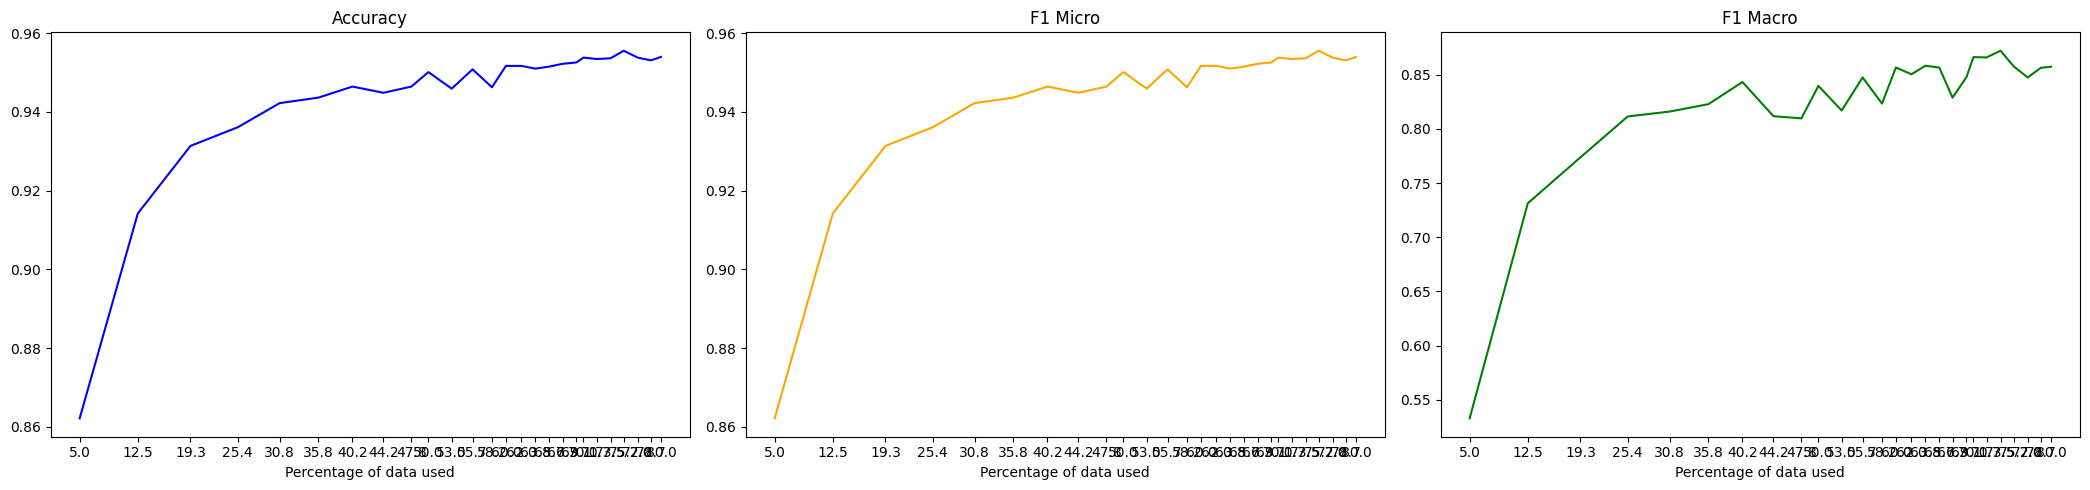

In [ ]:
active_learning(seeds[0], 0)

## RUN 2

TRIAL 2
Random seed: 81
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

EPOCH 1 | LOSS: 3.824376344680786 | ACCURACY: 0.8019 | F1 MACRO: 0.8841 | F1 MICRO: 0.8895
EPOCH 2 | LOSS: 3.5134222507476807 | ACCURACY: 0.8059 | F1 MACRO: 0.8817 | F1 MICRO: 0.8903
EPOCH 3 | LOSS: 3.267545700073242 | ACCURACY: 0.809 | F1 MACRO: 0.8821 | F1 MICRO: 0.8915
EPOCH 4 | LOSS: 3.003016948699951 | ACCURACY: 0.8078 | F1 MACRO: 0.8855 | F1 MICRO: 0.8919
EPOCH 5 | LOSS: 2.9384725093841553 | ACCURACY: 0.8132 | F1 MACRO: 0.8846 | F1 MICRO: 0.8935
EPOCH 6 | LOSS: 2.8934524059295654 | ACCURACY: 0.817 | F1 MACRO: 0.8869 | F1 MICRO: 0.8952
EPOCH 7 | LOSS: 2.808276414871216 | ACCURACY: 0.826 | F1 MACRO: 0.8929 | F1 MICRO: 0.9
EPOCH 8 | LOSS: 2.833528518676758 | ACCURACY: 0.834 | F1 MACRO: 0.8937 | F1 MICRO: 0.9032
EPOCH 9 | LOSS: 2.7288143634796143 | ACCURACY: 0.8495 | F1 MACRO: 0.9054 | F1 MICRO: 0.912
EPOCH 10 | LOSS: 2.673055410385132 | ACCURACY: 0.8604 | F1 MACRO: 0.9105 | F1 MICRO: 0.9176
aspect: ACCURACY 0.8604 | F1 MACRO 0.9105 | F1 MICRO 0.9176
              precision    recall

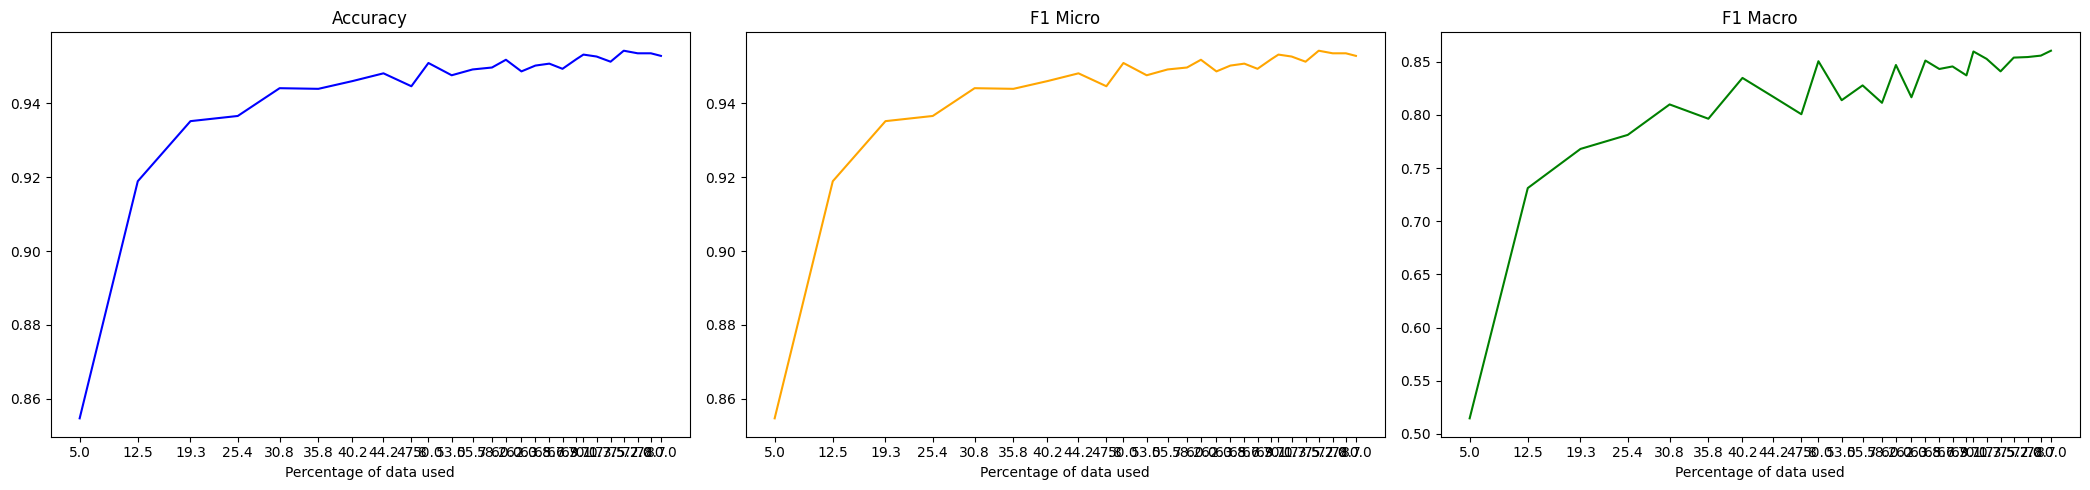

In [ ]:
active_learning(seeds[1], 1)

## RUN 3

TRIAL 3
Random seed: 14
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

EPOCH 1 | LOSS: 3.732823610305786 | ACCURACY: 0.7929 | F1 MACRO: 0.8755 | F1 MICRO: 0.8832
EPOCH 2 | LOSS: 3.627812623977661 | ACCURACY: 0.8012 | F1 MACRO: 0.8776 | F1 MICRO: 0.8873
EPOCH 3 | LOSS: 3.4145047664642334 | ACCURACY: 0.8024 | F1 MACRO: 0.8848 | F1 MICRO: 0.8898
EPOCH 4 | LOSS: 2.9772026538848877 | ACCURACY: 0.8167 | F1 MACRO: 0.8861 | F1 MICRO: 0.8952
EPOCH 5 | LOSS: 2.9456863403320312 | ACCURACY: 0.8153 | F1 MACRO: 0.8872 | F1 MICRO: 0.8948
EPOCH 6 | LOSS: 2.752725124359131 | ACCURACY: 0.8214 | F1 MACRO: 0.8901 | F1 MICRO: 0.8977
EPOCH 7 | LOSS: 2.7575175762176514 | ACCURACY: 0.8368 | F1 MACRO: 0.8979 | F1 MICRO: 0.9055
EPOCH 8 | LOSS: 2.724902868270874 | ACCURACY: 0.849 | F1 MACRO: 0.9046 | F1 MICRO: 0.9117
EPOCH 9 | LOSS: 2.790421962738037 | ACCURACY: 0.8552 | F1 MACRO: 0.909 | F1 MICRO: 0.9153
EPOCH 10 | LOSS: 2.7498550415039062 | ACCURACY: 0.8637 | F1 MACRO: 0.9114 | F1 MICRO: 0.9192
aspect: ACCURACY 0.8637 | F1 MACRO 0.9114 | F1 MICRO 0.9192
              precision   

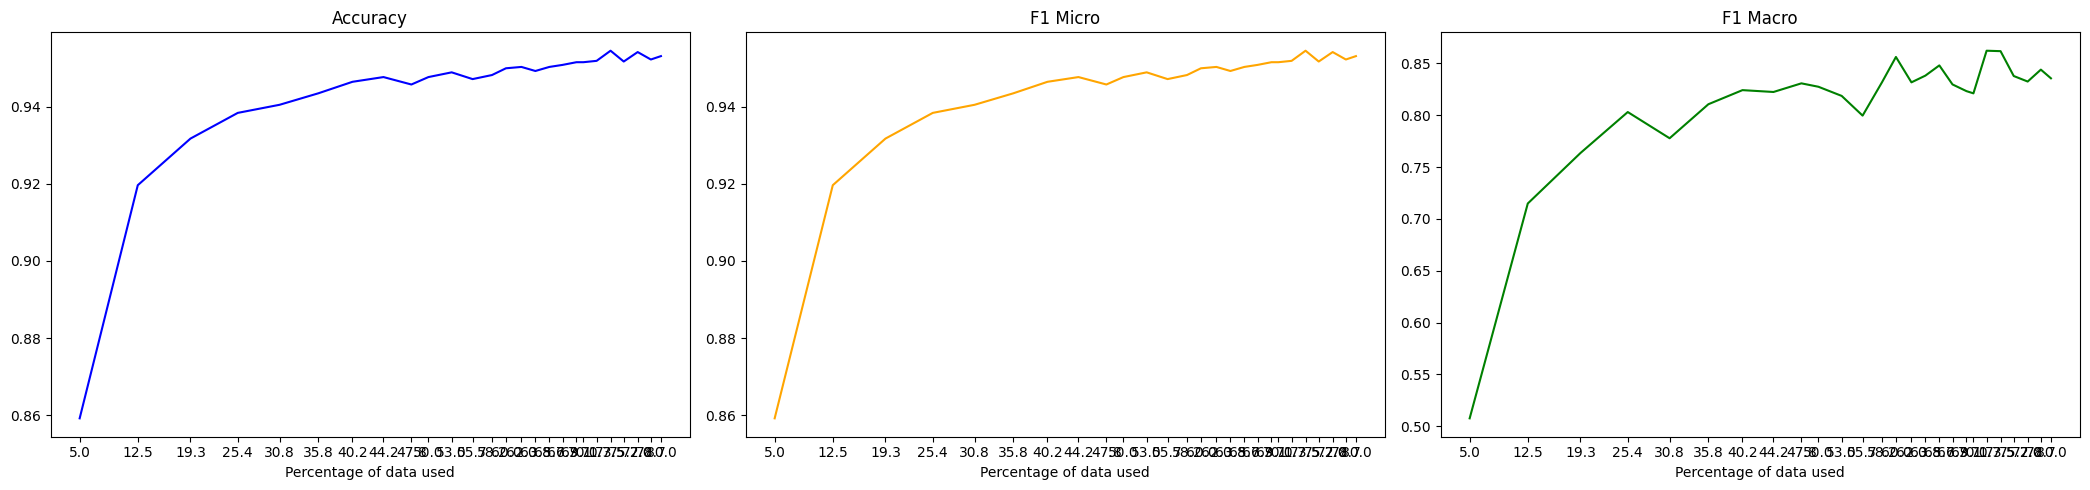

In [ ]:
active_learning(seeds[2], 2)

## RUN 4

TRIAL 4
Random seed: 3
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

EPOCH 1 | LOSS: 3.7112207412719727 | ACCURACY: 0.7998 | F1 MACRO: 0.8795 | F1 MICRO: 0.8873
EPOCH 2 | LOSS: 3.4030497074127197 | ACCURACY: 0.8014 | F1 MACRO: 0.8843 | F1 MICRO: 0.8892
EPOCH 3 | LOSS: 3.2661757469177246 | ACCURACY: 0.8021 | F1 MACRO: 0.8827 | F1 MICRO: 0.8885
EPOCH 4 | LOSS: 3.0314457416534424 | ACCURACY: 0.8092 | F1 MACRO: 0.8799 | F1 MICRO: 0.8902
EPOCH 5 | LOSS: 2.8283729553222656 | ACCURACY: 0.8123 | F1 MACRO: 0.8811 | F1 MICRO: 0.8921
EPOCH 6 | LOSS: 2.6874728202819824 | ACCURACY: 0.8196 | F1 MACRO: 0.8889 | F1 MICRO: 0.8966
EPOCH 7 | LOSS: 2.635066270828247 | ACCURACY: 0.8266 | F1 MACRO: 0.8915 | F1 MICRO: 0.8996
EPOCH 8 | LOSS: 2.6834709644317627 | ACCURACY: 0.8363 | F1 MACRO: 0.8957 | F1 MICRO: 0.9045
EPOCH 9 | LOSS: 2.665681838989258 | ACCURACY: 0.8502 | F1 MACRO: 0.9053 | F1 MICRO: 0.9122
EPOCH 10 | LOSS: 2.6654040813446045 | ACCURACY: 0.8566 | F1 MACRO: 0.9083 | F1 MICRO: 0.9152
aspect: ACCURACY 0.8566 | F1 MACRO 0.9083 | F1 MICRO 0.9152
              precisi

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 47.49348068237305 | ACCURACY: 0.7634 | F1 MACRO: 0.7531 | F1 MICRO: 0.7634
EPOCH 2 | LOSS: 39.5431022644043 | ACCURACY: 0.8034 | F1 MACRO: 0.7703 | F1 MICRO: 0.8034
EPOCH 3 | LOSS: 36.31126403808594 | ACCURACY: 0.8556 | F1 MACRO: 0.8504 | F1 MICRO: 0.8556
EPOCH 4 | LOSS: 33.813594818115234 | ACCURACY: 0.8694 | F1 MACRO: 0.8623 | F1 MICRO: 0.8694
EPOCH 5 | LOSS: 31.378671646118164 | ACCURACY: 0.8694 | F1 MACRO: 0.8617 | F1 MICRO: 0.8694
EPOCH 6 | LOSS: 29.509464263916016 | ACCURACY: 0.8756 | F1 MACRO: 0.868 | F1 MICRO: 0.8756
EPOCH 7 | LOSS: 28.0611572265625 | ACCURACY: 0.8955 | F1 MACRO: 0.8911 | F1 MICRO: 0.8955
EPOCH 8 | LOSS: 26.45145606994629 | ACCURACY: 0.8925 | F1 MACRO: 0.8872 | F1 MICRO: 0.8925
EPOCH 9 | LOSS: 25.716705322265625 | ACCURACY: 0.8618 | F1 MACRO: 0.8547 | F1 MICRO: 0.8618
EPOCH 10 | LOSS: 25.799972534179688 | ACCURACY: 0.874 | F1 MACRO: 0.8658 | F1 MICRO: 0.874
sentiment: ACCURACY 0.8955 | F1 MACRO 0.8911 | F1 MICRO 0.8955
              precision   

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 3.387885093688965 | ACCURACY: 0.8017 | F1 MACRO: 0.8814 | F1 MICRO: 0.888
EPOCH 2 | LOSS: 2.8900949954986572 | ACCURACY: 0.8139 | F1 MACRO: 0.8855 | F1 MICRO: 0.8939
EPOCH 3 | LOSS: 2.484851121902466 | ACCURACY: 0.8372 | F1 MACRO: 0.8974 | F1 MICRO: 0.9051
EPOCH 4 | LOSS: 2.4224870204925537 | ACCURACY: 0.8622 | F1 MACRO: 0.9123 | F1 MICRO: 0.9186
EPOCH 5 | LOSS: 2.450141191482544 | ACCURACY: 0.8845 | F1 MACRO: 0.9272 | F1 MICRO: 0.9314
EPOCH 6 | LOSS: 2.456662893295288 | ACCURACY: 0.891 | F1 MACRO: 0.931 | F1 MICRO: 0.9352
EPOCH 7 | LOSS: 2.3241450786590576 | ACCURACY: 0.9047 | F1 MACRO: 0.9391 | F1 MICRO: 0.9426
EPOCH 8 | LOSS: 2.272343873977661 | ACCURACY: 0.912 | F1 MACRO: 0.9434 | F1 MICRO: 0.9469
EPOCH 9 | LOSS: 2.1950056552886963 | ACCURACY: 0.92 | F1 MACRO: 0.9485 | F1 MICRO: 0.9517
EPOCH 10 | LOSS: 2.132107734680176 | ACCURACY: 0.9212 | F1 MACRO: 0.9485 | F1 MICRO: 0.9522
aspect: ACCURACY 0.9212 | F1 MACRO 0.9485 | F1 MICRO 0.9522
              precision    reca

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 23.99436378479004 | ACCURACY: 0.8284 | F1 MACRO: 0.7683 | F1 MICRO: 0.8284
EPOCH 2 | LOSS: 19.95570945739746 | ACCURACY: 0.8557 | F1 MACRO: 0.8131 | F1 MICRO: 0.8557
EPOCH 3 | LOSS: 18.676923751831055 | ACCURACY: 0.847 | F1 MACRO: 0.8111 | F1 MICRO: 0.847
EPOCH 4 | LOSS: 17.930606842041016 | ACCURACY: 0.8645 | F1 MACRO: 0.8167 | F1 MICRO: 0.8645
EPOCH 5 | LOSS: 17.17914390563965 | ACCURACY: 0.859 | F1 MACRO: 0.8085 | F1 MICRO: 0.859
EPOCH 6 | LOSS: 15.993837356567383 | ACCURACY: 0.8601 | F1 MACRO: 0.8168 | F1 MICRO: 0.8601
EPOCH 7 | LOSS: 15.522164344787598 | ACCURACY: 0.8743 | F1 MACRO: 0.8383 | F1 MICRO: 0.8743
EPOCH 8 | LOSS: 14.70765209197998 | ACCURACY: 0.8721 | F1 MACRO: 0.838 | F1 MICRO: 0.8721
EPOCH 9 | LOSS: 14.38473892211914 | ACCURACY: 0.8743 | F1 MACRO: 0.8435 | F1 MICRO: 0.8743
EPOCH 10 | LOSS: 14.43480110168457 | ACCURACY: 0.871 | F1 MACRO: 0.8453 | F1 MICRO: 0.871
sentiment: ACCURACY 0.8743 | F1 MACRO 0.8435 | F1 MICRO 0.8743
              precision    re

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 3.158341407775879 | ACCURACY: 0.8115 | F1 MACRO: 0.8849 | F1 MICRO: 0.8928
EPOCH 2 | LOSS: 2.54480242729187 | ACCURACY: 0.8368 | F1 MACRO: 0.8992 | F1 MICRO: 0.9058
EPOCH 3 | LOSS: 2.4128360748291016 | ACCURACY: 0.8819 | F1 MACRO: 0.925 | F1 MICRO: 0.9299
EPOCH 4 | LOSS: 2.4407753944396973 | ACCURACY: 0.9019 | F1 MACRO: 0.9371 | F1 MICRO: 0.9411
EPOCH 5 | LOSS: 2.334000825881958 | ACCURACY: 0.9205 | F1 MACRO: 0.9473 | F1 MICRO: 0.9516
EPOCH 6 | LOSS: 2.1938390731811523 | ACCURACY: 0.9259 | F1 MACRO: 0.9517 | F1 MICRO: 0.955
EPOCH 7 | LOSS: 2.0766360759735107 | ACCURACY: 0.9365 | F1 MACRO: 0.958 | F1 MICRO: 0.9611
EPOCH 8 | LOSS: 2.023118495941162 | ACCURACY: 0.9361 | F1 MACRO: 0.9572 | F1 MICRO: 0.9607
EPOCH 9 | LOSS: 1.9712576866149902 | ACCURACY: 0.937 | F1 MACRO: 0.958 | F1 MICRO: 0.9614
EPOCH 10 | LOSS: 1.8936920166015625 | ACCURACY: 0.9438 | F1 MACRO: 0.9615 | F1 MICRO: 0.9651
aspect: ACCURACY 0.9438 | F1 MACRO 0.9615 | F1 MICRO 0.9651
              precision    re

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 13.14669418334961 | ACCURACY: 0.8554 | F1 MACRO: 0.8122 | F1 MICRO: 0.8554
EPOCH 2 | LOSS: 10.596765518188477 | ACCURACY: 0.8698 | F1 MACRO: 0.8283 | F1 MICRO: 0.8698
EPOCH 3 | LOSS: 10.030287742614746 | ACCURACY: 0.8766 | F1 MACRO: 0.842 | F1 MICRO: 0.8766
EPOCH 4 | LOSS: 9.738081932067871 | ACCURACY: 0.8852 | F1 MACRO: 0.8526 | F1 MICRO: 0.8852
EPOCH 5 | LOSS: 9.150599479675293 | ACCURACY: 0.8968 | F1 MACRO: 0.8715 | F1 MICRO: 0.8968
EPOCH 6 | LOSS: 8.706320762634277 | ACCURACY: 0.893 | F1 MACRO: 0.8653 | F1 MICRO: 0.893
EPOCH 7 | LOSS: 8.576790809631348 | ACCURACY: 0.8872 | F1 MACRO: 0.8624 | F1 MICRO: 0.8872
EPOCH 8 | LOSS: 8.259124755859375 | ACCURACY: 0.8862 | F1 MACRO: 0.8605 | F1 MICRO: 0.8862
in second
EPOCH 9 | LOSS: 7.474303245544434 | ACCURACY: 0.8901 | F1 MACRO: 0.8639 | F1 MICRO: 0.8901
in second
EPOCH 10 | LOSS: 7.435836315155029 | ACCURACY: 0.892 | F1 MACRO: 0.8657 | F1 MICRO: 0.892
sentiment: ACCURACY 0.8968 | F1 MACRO 0.8715 | F1 MICRO 0.8968
         

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 2.960547685623169 | ACCURACY: 0.8231 | F1 MACRO: 0.8882 | F1 MICRO: 0.8981
EPOCH 2 | LOSS: 2.4068589210510254 | ACCURACY: 0.8856 | F1 MACRO: 0.9273 | F1 MICRO: 0.9321
EPOCH 3 | LOSS: 2.3792881965637207 | ACCURACY: 0.92 | F1 MACRO: 0.9476 | F1 MICRO: 0.9512
EPOCH 4 | LOSS: 2.1622557640075684 | ACCURACY: 0.9314 | F1 MACRO: 0.955 | F1 MICRO: 0.9582
EPOCH 5 | LOSS: 2.039914131164551 | ACCURACY: 0.9365 | F1 MACRO: 0.9579 | F1 MICRO: 0.9611
EPOCH 6 | LOSS: 1.9482225179672241 | ACCURACY: 0.9413 | F1 MACRO: 0.9602 | F1 MICRO: 0.9638
EPOCH 7 | LOSS: 1.8813525438308716 | ACCURACY: 0.9477 | F1 MACRO: 0.9643 | F1 MICRO: 0.9677
EPOCH 8 | LOSS: 1.8296469449996948 | ACCURACY: 0.9476 | F1 MACRO: 0.964 | F1 MICRO: 0.9674
EPOCH 9 | LOSS: 1.7570751905441284 | ACCURACY: 0.9465 | F1 MACRO: 0.9635 | F1 MICRO: 0.9671
EPOCH 10 | LOSS: 1.7217403650283813 | ACCURACY: 0.9481 | F1 MACRO: 0.9643 | F1 MICRO: 0.9677
aspect: ACCURACY 0.9477 | F1 MACRO 0.9643 | F1 MICRO 0.9677
              precision  

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 2.81411075592041 | ACCURACY: 0.8323 | F1 MACRO: 0.8945 | F1 MICRO: 0.9029
EPOCH 2 | LOSS: 2.3863697052001953 | ACCURACY: 0.8998 | F1 MACRO: 0.9356 | F1 MICRO: 0.94
EPOCH 3 | LOSS: 2.2582848072052 | ACCURACY: 0.9273 | F1 MACRO: 0.9522 | F1 MICRO: 0.9555
EPOCH 4 | LOSS: 2.069300413131714 | ACCURACY: 0.9384 | F1 MACRO: 0.9591 | F1 MICRO: 0.9622
EPOCH 5 | LOSS: 1.9557100534439087 | ACCURACY: 0.9401 | F1 MACRO: 0.96 | F1 MICRO: 0.9633
EPOCH 6 | LOSS: 1.8761638402938843 | ACCURACY: 0.9451 | F1 MACRO: 0.963 | F1 MICRO: 0.9662
EPOCH 7 | LOSS: 1.8043639659881592 | ACCURACY: 0.949 | F1 MACRO: 0.9648 | F1 MICRO: 0.9684
EPOCH 8 | LOSS: 1.7422826290130615 | ACCURACY: 0.9516 | F1 MACRO: 0.9661 | F1 MICRO: 0.9699
EPOCH 9 | LOSS: 1.7026686668395996 | ACCURACY: 0.9512 | F1 MACRO: 0.9661 | F1 MICRO: 0.9697
EPOCH 10 | LOSS: 1.6664491891860962 | ACCURACY: 0.9524 | F1 MACRO: 0.9674 | F1 MICRO: 0.9706
aspect: ACCURACY 0.9524 | F1 MACRO 0.9674 | F1 MICRO 0.9706
              precision    reca

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 9.924132347106934 | ACCURACY: 0.8532 | F1 MACRO: 0.7993 | F1 MICRO: 0.8532
EPOCH 2 | LOSS: 7.9380621910095215 | ACCURACY: 0.8796 | F1 MACRO: 0.8489 | F1 MICRO: 0.8796
EPOCH 3 | LOSS: 7.440136432647705 | ACCURACY: 0.8918 | F1 MACRO: 0.8658 | F1 MICRO: 0.8918
EPOCH 4 | LOSS: 7.141768932342529 | ACCURACY: 0.889 | F1 MACRO: 0.8589 | F1 MICRO: 0.889
EPOCH 5 | LOSS: 6.762828350067139 | ACCURACY: 0.889 | F1 MACRO: 0.856 | F1 MICRO: 0.889
EPOCH 6 | LOSS: 6.467101573944092 | ACCURACY: 0.9003 | F1 MACRO: 0.8762 | F1 MICRO: 0.9003
EPOCH 7 | LOSS: 6.253941535949707 | ACCURACY: 0.8928 | F1 MACRO: 0.866 | F1 MICRO: 0.8928
EPOCH 8 | LOSS: 6.10391902923584 | ACCURACY: 0.8946 | F1 MACRO: 0.8652 | F1 MICRO: 0.8946
EPOCH 9 | LOSS: 5.992030143737793 | ACCURACY: 0.9003 | F1 MACRO: 0.8741 | F1 MICRO: 0.9003
EPOCH 10 | LOSS: 5.877194881439209 | ACCURACY: 0.9003 | F1 MACRO: 0.8724 | F1 MICRO: 0.9003
sentiment: ACCURACY 0.9003 | F1 MACRO 0.8724 | F1 MICRO 0.9003
              precision    recal

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 8.546924591064453 | ACCURACY: 0.8295 | F1 MACRO: 0.7665 | F1 MICRO: 0.8295
EPOCH 2 | LOSS: 7.142628192901611 | ACCURACY: 0.876 | F1 MACRO: 0.8403 | F1 MICRO: 0.876
EPOCH 3 | LOSS: 6.705692291259766 | ACCURACY: 0.8541 | F1 MACRO: 0.8025 | F1 MICRO: 0.8541
EPOCH 4 | LOSS: 6.360671043395996 | ACCURACY: 0.8915 | F1 MACRO: 0.8628 | F1 MICRO: 0.8915
EPOCH 5 | LOSS: 6.070188999176025 | ACCURACY: 0.8733 | F1 MACRO: 0.8477 | F1 MICRO: 0.8733
EPOCH 6 | LOSS: 6.035336494445801 | ACCURACY: 0.8906 | F1 MACRO: 0.8603 | F1 MICRO: 0.8906
EPOCH 7 | LOSS: 5.64758825302124 | ACCURACY: 0.8851 | F1 MACRO: 0.853 | F1 MICRO: 0.8851
in second
EPOCH 8 | LOSS: 5.15814208984375 | ACCURACY: 0.8924 | F1 MACRO: 0.8641 | F1 MICRO: 0.8924
in second
EPOCH 9 | LOSS: 5.080453872680664 | ACCURACY: 0.8924 | F1 MACRO: 0.8638 | F1 MICRO: 0.8924
in second
EPOCH 10 | LOSS: 5.05667781829834 | ACCURACY: 0.8933 | F1 MACRO: 0.8654 | F1 MICRO: 0.8933
sentiment: ACCURACY 0.8915 | F1 MACRO 0.8628 | F1 MICRO 0.8915
  

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 2.7626657485961914 | ACCURACY: 0.8535 | F1 MACRO: 0.9078 | F1 MICRO: 0.9141
EPOCH 2 | LOSS: 2.326162576675415 | ACCURACY: 0.9198 | F1 MACRO: 0.9485 | F1 MICRO: 0.9516
EPOCH 3 | LOSS: 2.143608570098877 | ACCURACY: 0.934 | F1 MACRO: 0.956 | F1 MICRO: 0.9595
EPOCH 4 | LOSS: 1.9990578889846802 | ACCURACY: 0.9448 | F1 MACRO: 0.9629 | F1 MICRO: 0.966
EPOCH 5 | LOSS: 1.897887110710144 | ACCURACY: 0.9488 | F1 MACRO: 0.965 | F1 MICRO: 0.9684
EPOCH 6 | LOSS: 1.7997506856918335 | ACCURACY: 0.9509 | F1 MACRO: 0.9662 | F1 MICRO: 0.9696
EPOCH 7 | LOSS: 1.7455813884735107 | ACCURACY: 0.9533 | F1 MACRO: 0.9679 | F1 MICRO: 0.971
EPOCH 8 | LOSS: 1.7079187631607056 | ACCURACY: 0.9554 | F1 MACRO: 0.9693 | F1 MICRO: 0.9723
EPOCH 9 | LOSS: 1.65269935131073 | ACCURACY: 0.9552 | F1 MACRO: 0.9695 | F1 MICRO: 0.9723
EPOCH 10 | LOSS: 1.6143112182617188 | ACCURACY: 0.9542 | F1 MACRO: 0.9686 | F1 MICRO: 0.9717
aspect: ACCURACY 0.9554 | F1 MACRO 0.9693 | F1 MICRO 0.9723
              precision    re

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 7.96569299697876 | ACCURACY: 0.8506 | F1 MACRO: 0.8153 | F1 MICRO: 0.8506
EPOCH 2 | LOSS: 6.473095893859863 | ACCURACY: 0.8607 | F1 MACRO: 0.8164 | F1 MICRO: 0.8607
EPOCH 3 | LOSS: 6.078282833099365 | ACCURACY: 0.8807 | F1 MACRO: 0.8499 | F1 MICRO: 0.8807
EPOCH 4 | LOSS: 5.7313232421875 | ACCURACY: 0.8752 | F1 MACRO: 0.8437 | F1 MICRO: 0.8752
EPOCH 5 | LOSS: 5.564035892486572 | ACCURACY: 0.8852 | F1 MACRO: 0.8558 | F1 MICRO: 0.8852
EPOCH 6 | LOSS: 5.301775932312012 | ACCURACY: 0.8862 | F1 MACRO: 0.8613 | F1 MICRO: 0.8862
EPOCH 7 | LOSS: 5.184568881988525 | ACCURACY: 0.8807 | F1 MACRO: 0.8487 | F1 MICRO: 0.8807
EPOCH 8 | LOSS: 4.988490104675293 | ACCURACY: 0.8679 | F1 MACRO: 0.8264 | F1 MICRO: 0.8679
EPOCH 9 | LOSS: 4.828641891479492 | ACCURACY: 0.8798 | F1 MACRO: 0.849 | F1 MICRO: 0.8798
in second
EPOCH 10 | LOSS: 4.544742107391357 | ACCURACY: 0.8907 | F1 MACRO: 0.8627 | F1 MICRO: 0.8907
sentiment: ACCURACY 0.8862 | F1 MACRO 0.8613 | F1 MICRO 0.8862
              precis

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 6.559548854827881 | ACCURACY: 0.8435 | F1 MACRO: 0.781 | F1 MICRO: 0.8435
EPOCH 2 | LOSS: 5.380877494812012 | ACCURACY: 0.8835 | F1 MACRO: 0.853 | F1 MICRO: 0.8835
EPOCH 3 | LOSS: 4.956818580627441 | ACCURACY: 0.8908 | F1 MACRO: 0.8639 | F1 MICRO: 0.8908
EPOCH 4 | LOSS: 4.734734535217285 | ACCURACY: 0.899 | F1 MACRO: 0.8724 | F1 MICRO: 0.899
EPOCH 5 | LOSS: 4.435275077819824 | ACCURACY: 0.8954 | F1 MACRO: 0.8678 | F1 MICRO: 0.8954
EPOCH 6 | LOSS: 4.360727787017822 | ACCURACY: 0.8954 | F1 MACRO: 0.8666 | F1 MICRO: 0.8954
EPOCH 7 | LOSS: 4.26932430267334 | ACCURACY: 0.8954 | F1 MACRO: 0.8704 | F1 MICRO: 0.8954
in second
EPOCH 8 | LOSS: 3.9295151233673096 | ACCURACY: 0.899 | F1 MACRO: 0.8737 | F1 MICRO: 0.899
in second
EPOCH 9 | LOSS: 3.8981902599334717 | ACCURACY: 0.8999 | F1 MACRO: 0.8744 | F1 MICRO: 0.8999
in second
EPOCH 10 | LOSS: 3.8620691299438477 | ACCURACY: 0.8981 | F1 MACRO: 0.8727 | F1 MICRO: 0.8981
sentiment: ACCURACY 0.899 | F1 MACRO 0.8724 | F1 MICRO 0.899
  

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 6.309693336486816 | ACCURACY: 0.8432 | F1 MACRO: 0.7988 | F1 MICRO: 0.8432
EPOCH 2 | LOSS: 4.993736743927002 | ACCURACY: 0.8676 | F1 MACRO: 0.8269 | F1 MICRO: 0.8676
EPOCH 3 | LOSS: 4.795984268188477 | ACCURACY: 0.8867 | F1 MACRO: 0.8562 | F1 MICRO: 0.8867
EPOCH 4 | LOSS: 4.573017120361328 | ACCURACY: 0.8849 | F1 MACRO: 0.8551 | F1 MICRO: 0.8849
EPOCH 5 | LOSS: 4.267396926879883 | ACCURACY: 0.8939 | F1 MACRO: 0.8651 | F1 MICRO: 0.8939
EPOCH 6 | LOSS: 4.204034805297852 | ACCURACY: 0.8876 | F1 MACRO: 0.8617 | F1 MICRO: 0.8876
EPOCH 7 | LOSS: 4.072166919708252 | ACCURACY: 0.8912 | F1 MACRO: 0.8609 | F1 MICRO: 0.8912
EPOCH 8 | LOSS: 3.9701967239379883 | ACCURACY: 0.8894 | F1 MACRO: 0.8598 | F1 MICRO: 0.8894
in second
EPOCH 9 | LOSS: 3.677915334701538 | ACCURACY: 0.893 | F1 MACRO: 0.8663 | F1 MICRO: 0.893
in second
EPOCH 10 | LOSS: 3.66960072517395 | ACCURACY: 0.8939 | F1 MACRO: 0.8648 | F1 MICRO: 0.8939
sentiment: ACCURACY 0.8939 | F1 MACRO 0.8651 | F1 MICRO 0.8939
        

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 5.795469284057617 | ACCURACY: 0.8605 | F1 MACRO: 0.8257 | F1 MICRO: 0.8605
EPOCH 2 | LOSS: 4.70222806930542 | ACCURACY: 0.8736 | F1 MACRO: 0.8493 | F1 MICRO: 0.8736
EPOCH 3 | LOSS: 4.427309989929199 | ACCURACY: 0.8951 | F1 MACRO: 0.866 | F1 MICRO: 0.8951
EPOCH 4 | LOSS: 4.213372707366943 | ACCURACY: 0.8961 | F1 MACRO: 0.8636 | F1 MICRO: 0.8961
EPOCH 5 | LOSS: 4.001113414764404 | ACCURACY: 0.8923 | F1 MACRO: 0.8641 | F1 MICRO: 0.8923
EPOCH 6 | LOSS: 3.8872601985931396 | ACCURACY: 0.8979 | F1 MACRO: 0.8722 | F1 MICRO: 0.8979
EPOCH 7 | LOSS: 3.788348436355591 | ACCURACY: 0.9064 | F1 MACRO: 0.8798 | F1 MICRO: 0.9064
EPOCH 8 | LOSS: 3.621217727661133 | ACCURACY: 0.9101 | F1 MACRO: 0.8844 | F1 MICRO: 0.9101
EPOCH 9 | LOSS: 3.5833992958068848 | ACCURACY: 0.9007 | F1 MACRO: 0.8759 | F1 MICRO: 0.9007
EPOCH 10 | LOSS: 3.491082191467285 | ACCURACY: 0.9036 | F1 MACRO: 0.8743 | F1 MICRO: 0.9036
sentiment: ACCURACY 0.9101 | F1 MACRO 0.8844 | F1 MICRO 0.9101
              precision   

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 5.7403459548950195 | ACCURACY: 0.8658 | F1 MACRO: 0.8295 | F1 MICRO: 0.8658
EPOCH 2 | LOSS: 4.587234020233154 | ACCURACY: 0.8952 | F1 MACRO: 0.8642 | F1 MICRO: 0.8952
EPOCH 3 | LOSS: 4.215862274169922 | ACCURACY: 0.8943 | F1 MACRO: 0.8653 | F1 MICRO: 0.8943
EPOCH 4 | LOSS: 4.037764549255371 | ACCURACY: 0.9026 | F1 MACRO: 0.8778 | F1 MICRO: 0.9026
EPOCH 5 | LOSS: 3.9593238830566406 | ACCURACY: 0.898 | F1 MACRO: 0.8716 | F1 MICRO: 0.898
EPOCH 6 | LOSS: 3.804962396621704 | ACCURACY: 0.9026 | F1 MACRO: 0.8762 | F1 MICRO: 0.9026
EPOCH 7 | LOSS: 3.666804313659668 | ACCURACY: 0.898 | F1 MACRO: 0.87 | F1 MICRO: 0.898
EPOCH 8 | LOSS: 3.647284746170044 | ACCURACY: 0.8934 | F1 MACRO: 0.8643 | F1 MICRO: 0.8934
EPOCH 9 | LOSS: 3.5691840648651123 | ACCURACY: 0.9053 | F1 MACRO: 0.8783 | F1 MICRO: 0.9053
EPOCH 10 | LOSS: 3.4577927589416504 | ACCURACY: 0.9026 | F1 MACRO: 0.8734 | F1 MICRO: 0.9026
sentiment: ACCURACY 0.9053 | F1 MACRO 0.8783 | F1 MICRO 0.9053
              precision    r

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 2.6451947689056396 | ACCURACY: 0.8845 | F1 MACRO: 0.9267 | F1 MICRO: 0.9315
EPOCH 2 | LOSS: 2.226855516433716 | ACCURACY: 0.9335 | F1 MACRO: 0.9559 | F1 MICRO: 0.9592
EPOCH 3 | LOSS: 2.0055699348449707 | ACCURACY: 0.9438 | F1 MACRO: 0.9624 | F1 MICRO: 0.9654
EPOCH 4 | LOSS: 1.8614310026168823 | ACCURACY: 0.9516 | F1 MACRO: 0.9673 | F1 MICRO: 0.97
EPOCH 5 | LOSS: 1.7909668684005737 | ACCURACY: 0.9526 | F1 MACRO: 0.9673 | F1 MICRO: 0.9706
EPOCH 6 | LOSS: 1.714416742324829 | ACCURACY: 0.953 | F1 MACRO: 0.9677 | F1 MICRO: 0.9708
EPOCH 7 | LOSS: 1.671396255493164 | ACCURACY: 0.9552 | F1 MACRO: 0.9695 | F1 MICRO: 0.9723
EPOCH 8 | LOSS: 1.6226577758789062 | ACCURACY: 0.9542 | F1 MACRO: 0.9686 | F1 MICRO: 0.9716
EPOCH 9 | LOSS: 1.6059646606445312 | ACCURACY: 0.958 | F1 MACRO: 0.9711 | F1 MICRO: 0.9739
EPOCH 10 | LOSS: 1.5656251907348633 | ACCURACY: 0.9597 | F1 MACRO: 0.9721 | F1 MICRO: 0.975
aspect: ACCURACY 0.9597 | F1 MACRO 0.9721 | F1 MICRO 0.975
              precision    r

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 2.6099038124084473 | ACCURACY: 0.8844 | F1 MACRO: 0.9253 | F1 MICRO: 0.9308
EPOCH 2 | LOSS: 2.2086007595062256 | ACCURACY: 0.9347 | F1 MACRO: 0.9566 | F1 MICRO: 0.9599
EPOCH 3 | LOSS: 1.9844039678573608 | ACCURACY: 0.9427 | F1 MACRO: 0.962 | F1 MICRO: 0.9649
EPOCH 4 | LOSS: 1.8882696628570557 | ACCURACY: 0.9526 | F1 MACRO: 0.968 | F1 MICRO: 0.9707
EPOCH 5 | LOSS: 1.7813156843185425 | ACCURACY: 0.9547 | F1 MACRO: 0.9692 | F1 MICRO: 0.9719
EPOCH 6 | LOSS: 1.703365445137024 | ACCURACY: 0.958 | F1 MACRO: 0.9709 | F1 MICRO: 0.9739
EPOCH 7 | LOSS: 1.6535426378250122 | ACCURACY: 0.9568 | F1 MACRO: 0.9704 | F1 MICRO: 0.9732
EPOCH 8 | LOSS: 1.6034127473831177 | ACCURACY: 0.9566 | F1 MACRO: 0.9701 | F1 MICRO: 0.973
EPOCH 9 | LOSS: 1.5775359869003296 | ACCURACY: 0.9576 | F1 MACRO: 0.9717 | F1 MICRO: 0.9739
EPOCH 10 | LOSS: 1.557508111000061 | ACCURACY: 0.959 | F1 MACRO: 0.9719 | F1 MICRO: 0.9746
aspect: ACCURACY 0.959 | F1 MACRO 0.9719 | F1 MICRO 0.9746
              precision    

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 5.4430060386657715 | ACCURACY: 0.8486 | F1 MACRO: 0.8013 | F1 MICRO: 0.8486
EPOCH 2 | LOSS: 4.454872131347656 | ACCURACY: 0.8721 | F1 MACRO: 0.8339 | F1 MICRO: 0.8721
EPOCH 3 | LOSS: 4.159299850463867 | ACCURACY: 0.8793 | F1 MACRO: 0.8385 | F1 MICRO: 0.8793
EPOCH 4 | LOSS: 3.9157161712646484 | ACCURACY: 0.8856 | F1 MACRO: 0.8557 | F1 MICRO: 0.8856
EPOCH 5 | LOSS: 3.7423553466796875 | ACCURACY: 0.8901 | F1 MACRO: 0.8592 | F1 MICRO: 0.8901
EPOCH 6 | LOSS: 3.6284923553466797 | ACCURACY: 0.8946 | F1 MACRO: 0.8679 | F1 MICRO: 0.8946
EPOCH 7 | LOSS: 3.535414218902588 | ACCURACY: 0.891 | F1 MACRO: 0.8586 | F1 MICRO: 0.891
EPOCH 8 | LOSS: 3.4429304599761963 | ACCURACY: 0.8883 | F1 MACRO: 0.8543 | F1 MICRO: 0.8883
EPOCH 9 | LOSS: 3.3693387508392334 | ACCURACY: 0.8874 | F1 MACRO: 0.8568 | F1 MICRO: 0.8874
in second
EPOCH 10 | LOSS: 3.198793888092041 | ACCURACY: 0.891 | F1 MACRO: 0.8602 | F1 MICRO: 0.891
sentiment: ACCURACY 0.8946 | F1 MACRO 0.8679 | F1 MICRO 0.8946
              

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 2.608347177505493 | ACCURACY: 0.8878 | F1 MACRO: 0.929 | F1 MICRO: 0.9334
EPOCH 2 | LOSS: 2.2073006629943848 | ACCURACY: 0.9392 | F1 MACRO: 0.9603 | F1 MICRO: 0.9628
EPOCH 3 | LOSS: 1.9663965702056885 | ACCURACY: 0.9479 | F1 MACRO: 0.9652 | F1 MICRO: 0.968
EPOCH 4 | LOSS: 1.8388038873672485 | ACCURACY: 0.9564 | F1 MACRO: 0.9699 | F1 MICRO: 0.973
EPOCH 5 | LOSS: 1.7590161561965942 | ACCURACY: 0.95 | F1 MACRO: 0.9663 | F1 MICRO: 0.9691
EPOCH 6 | LOSS: 1.6963571310043335 | ACCURACY: 0.9571 | F1 MACRO: 0.9708 | F1 MICRO: 0.9735
EPOCH 7 | LOSS: 1.6384282112121582 | ACCURACY: 0.9545 | F1 MACRO: 0.9686 | F1 MICRO: 0.9718
EPOCH 8 | LOSS: 1.6100668907165527 | ACCURACY: 0.9573 | F1 MACRO: 0.971 | F1 MICRO: 0.9735
EPOCH 9 | LOSS: 1.5806535482406616 | ACCURACY: 0.9569 | F1 MACRO: 0.9707 | F1 MICRO: 0.9733
in second
EPOCH 10 | LOSS: 1.5038366317749023 | ACCURACY: 0.9583 | F1 MACRO: 0.9719 | F1 MICRO: 0.9743
aspect: ACCURACY 0.9571 | F1 MACRO 0.9708 | F1 MICRO 0.9735
              pr

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 2.604140043258667 | ACCURACY: 0.8924 | F1 MACRO: 0.9307 | F1 MICRO: 0.9358
EPOCH 2 | LOSS: 2.1649203300476074 | ACCURACY: 0.9323 | F1 MACRO: 0.9553 | F1 MICRO: 0.9586
EPOCH 3 | LOSS: 1.9390093088150024 | ACCURACY: 0.9491 | F1 MACRO: 0.9652 | F1 MICRO: 0.9686
EPOCH 4 | LOSS: 1.8270008563995361 | ACCURACY: 0.9526 | F1 MACRO: 0.968 | F1 MICRO: 0.9708
EPOCH 5 | LOSS: 1.731428623199463 | ACCURACY: 0.951 | F1 MACRO: 0.967 | F1 MICRO: 0.9698
EPOCH 6 | LOSS: 1.676856279373169 | ACCURACY: 0.9575 | F1 MACRO: 0.9707 | F1 MICRO: 0.9736
EPOCH 7 | LOSS: 1.6315162181854248 | ACCURACY: 0.9566 | F1 MACRO: 0.9706 | F1 MICRO: 0.9732
EPOCH 8 | LOSS: 1.5933393239974976 | ACCURACY: 0.9568 | F1 MACRO: 0.9707 | F1 MICRO: 0.9732
EPOCH 9 | LOSS: 1.5702381134033203 | ACCURACY: 0.9533 | F1 MACRO: 0.9679 | F1 MICRO: 0.9712
in second
EPOCH 10 | LOSS: 1.4826571941375732 | ACCURACY: 0.9587 | F1 MACRO: 0.9721 | F1 MICRO: 0.9745
aspect: ACCURACY 0.9575 | F1 MACRO 0.9707 | F1 MICRO 0.9736
              p

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 2.599954128265381 | ACCURACY: 0.8974 | F1 MACRO: 0.9334 | F1 MICRO: 0.9383
EPOCH 2 | LOSS: 2.1662425994873047 | ACCURACY: 0.9377 | F1 MACRO: 0.9591 | F1 MICRO: 0.9619
EPOCH 3 | LOSS: 1.9412211179733276 | ACCURACY: 0.9497 | F1 MACRO: 0.966 | F1 MICRO: 0.969
EPOCH 4 | LOSS: 1.819999098777771 | ACCURACY: 0.9517 | F1 MACRO: 0.9673 | F1 MICRO: 0.9702
EPOCH 5 | LOSS: 1.752509593963623 | ACCURACY: 0.9552 | F1 MACRO: 0.9693 | F1 MICRO: 0.9723
EPOCH 6 | LOSS: 1.6806727647781372 | ACCURACY: 0.9557 | F1 MACRO: 0.97 | F1 MICRO: 0.9727
EPOCH 7 | LOSS: 1.6336469650268555 | ACCURACY: 0.9589 | F1 MACRO: 0.972 | F1 MICRO: 0.9744
EPOCH 8 | LOSS: 1.6162203550338745 | ACCURACY: 0.9587 | F1 MACRO: 0.9718 | F1 MICRO: 0.9744
EPOCH 9 | LOSS: 1.5664112567901611 | ACCURACY: 0.9549 | F1 MACRO: 0.9697 | F1 MICRO: 0.9721
EPOCH 10 | LOSS: 1.536877155303955 | ACCURACY: 0.9578 | F1 MACRO: 0.9714 | F1 MICRO: 0.9738
aspect: ACCURACY 0.9589 | F1 MACRO 0.972 | F1 MICRO 0.9744
              precision    re

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 4.948444366455078 | ACCURACY: 0.8339 | F1 MACRO: 0.7742 | F1 MICRO: 0.8339
EPOCH 2 | LOSS: 4.044108867645264 | ACCURACY: 0.8696 | F1 MACRO: 0.8302 | F1 MICRO: 0.8696
EPOCH 3 | LOSS: 3.7160611152648926 | ACCURACY: 0.8839 | F1 MACRO: 0.8533 | F1 MICRO: 0.8839
EPOCH 4 | LOSS: 3.5157666206359863 | ACCURACY: 0.875 | F1 MACRO: 0.8345 | F1 MICRO: 0.875
EPOCH 5 | LOSS: 3.425030469894409 | ACCURACY: 0.8857 | F1 MACRO: 0.8564 | F1 MICRO: 0.8857
EPOCH 6 | LOSS: 3.2315163612365723 | ACCURACY: 0.892 | F1 MACRO: 0.8615 | F1 MICRO: 0.892
EPOCH 7 | LOSS: 3.1753265857696533 | ACCURACY: 0.8866 | F1 MACRO: 0.8588 | F1 MICRO: 0.8866
EPOCH 8 | LOSS: 3.0669753551483154 | ACCURACY: 0.8911 | F1 MACRO: 0.8614 | F1 MICRO: 0.8911
EPOCH 9 | LOSS: 3.013016700744629 | ACCURACY: 0.8857 | F1 MACRO: 0.8534 | F1 MICRO: 0.8857
in second
EPOCH 10 | LOSS: 2.8738856315612793 | ACCURACY: 0.8946 | F1 MACRO: 0.8674 | F1 MICRO: 0.8946
sentiment: ACCURACY 0.892 | F1 MACRO 0.8615 | F1 MICRO 0.892
              pr

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 2.5739474296569824 | ACCURACY: 0.8925 | F1 MACRO: 0.9318 | F1 MICRO: 0.9362
EPOCH 2 | LOSS: 2.1590805053710938 | ACCURACY: 0.9399 | F1 MACRO: 0.9604 | F1 MICRO: 0.9632
EPOCH 3 | LOSS: 1.9287086725234985 | ACCURACY: 0.9502 | F1 MACRO: 0.9668 | F1 MICRO: 0.9694
EPOCH 4 | LOSS: 1.8192509412765503 | ACCURACY: 0.9519 | F1 MACRO: 0.9676 | F1 MICRO: 0.9704
EPOCH 5 | LOSS: 1.7231491804122925 | ACCURACY: 0.9559 | F1 MACRO: 0.9697 | F1 MICRO: 0.9727
EPOCH 6 | LOSS: 1.6614400148391724 | ACCURACY: 0.959 | F1 MACRO: 0.9718 | F1 MICRO: 0.9746
EPOCH 7 | LOSS: 1.6380352973937988 | ACCURACY: 0.9563 | F1 MACRO: 0.9701 | F1 MICRO: 0.9729
EPOCH 8 | LOSS: 1.579114556312561 | ACCURACY: 0.9597 | F1 MACRO: 0.9726 | F1 MICRO: 0.975
EPOCH 9 | LOSS: 1.5657894611358643 | ACCURACY: 0.9576 | F1 MACRO: 0.9712 | F1 MICRO: 0.9738
EPOCH 10 | LOSS: 1.525317668914795 | ACCURACY: 0.9578 | F1 MACRO: 0.9713 | F1 MICRO: 0.9738
aspect: ACCURACY 0.9597 | F1 MACRO 0.9726 | F1 MICRO 0.975
              precision 

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 4.806407928466797 | ACCURACY: 0.8579 | F1 MACRO: 0.816 | F1 MICRO: 0.8579
EPOCH 2 | LOSS: 3.794468641281128 | ACCURACY: 0.8761 | F1 MACRO: 0.8424 | F1 MICRO: 0.8761
EPOCH 3 | LOSS: 3.5629494190216064 | ACCURACY: 0.877 | F1 MACRO: 0.8391 | F1 MICRO: 0.877
EPOCH 4 | LOSS: 3.3476507663726807 | ACCURACY: 0.8962 | F1 MACRO: 0.8656 | F1 MICRO: 0.8962
EPOCH 5 | LOSS: 3.2077648639678955 | ACCURACY: 0.8916 | F1 MACRO: 0.8631 | F1 MICRO: 0.8916
EPOCH 6 | LOSS: 3.1354613304138184 | ACCURACY: 0.8989 | F1 MACRO: 0.8692 | F1 MICRO: 0.8989
EPOCH 7 | LOSS: 3.0243680477142334 | ACCURACY: 0.8698 | F1 MACRO: 0.8224 | F1 MICRO: 0.8698
EPOCH 8 | LOSS: 2.961210012435913 | ACCURACY: 0.8944 | F1 MACRO: 0.8647 | F1 MICRO: 0.8944
EPOCH 9 | LOSS: 2.923461437225342 | ACCURACY: 0.8998 | F1 MACRO: 0.8736 | F1 MICRO: 0.8998
EPOCH 10 | LOSS: 2.9500961303710938 | ACCURACY: 0.8898 | F1 MACRO: 0.8571 | F1 MICRO: 0.8898
sentiment: ACCURACY 0.8998 | F1 MACRO 0.8736 | F1 MICRO 0.8998
              precision

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 4.6156697273254395 | ACCURACY: 0.8447 | F1 MACRO: 0.7784 | F1 MICRO: 0.8447
EPOCH 2 | LOSS: 3.705702304840088 | ACCURACY: 0.8824 | F1 MACRO: 0.8492 | F1 MICRO: 0.8824
EPOCH 3 | LOSS: 3.466026544570923 | ACCURACY: 0.8888 | F1 MACRO: 0.8595 | F1 MICRO: 0.8888
EPOCH 4 | LOSS: 3.299415349960327 | ACCURACY: 0.8888 | F1 MACRO: 0.8504 | F1 MICRO: 0.8888
EPOCH 5 | LOSS: 3.1116325855255127 | ACCURACY: 0.8824 | F1 MACRO: 0.8412 | F1 MICRO: 0.8824
EPOCH 6 | LOSS: 3.017683982849121 | ACCURACY: 0.9007 | F1 MACRO: 0.8713 | F1 MICRO: 0.9007
EPOCH 7 | LOSS: 2.950153350830078 | ACCURACY: 0.8915 | F1 MACRO: 0.8622 | F1 MICRO: 0.8915
EPOCH 8 | LOSS: 2.8876309394836426 | ACCURACY: 0.8888 | F1 MACRO: 0.8601 | F1 MICRO: 0.8888
EPOCH 9 | LOSS: 2.824390411376953 | ACCURACY: 0.8879 | F1 MACRO: 0.8572 | F1 MICRO: 0.8879
in second
EPOCH 10 | LOSS: 2.6998162269592285 | ACCURACY: 0.898 | F1 MACRO: 0.8685 | F1 MICRO: 0.898
sentiment: ACCURACY 0.9007 | F1 MACRO 0.8713 | F1 MICRO 0.9007
              

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 2.567852020263672 | ACCURACY: 0.8938 | F1 MACRO: 0.9313 | F1 MICRO: 0.9366
EPOCH 2 | LOSS: 2.1488840579986572 | ACCURACY: 0.9415 | F1 MACRO: 0.9621 | F1 MICRO: 0.9643
EPOCH 3 | LOSS: 1.9229968786239624 | ACCURACY: 0.9477 | F1 MACRO: 0.9649 | F1 MICRO: 0.9678
EPOCH 4 | LOSS: 1.8199234008789062 | ACCURACY: 0.9545 | F1 MACRO: 0.9692 | F1 MICRO: 0.9718
EPOCH 5 | LOSS: 1.7184714078903198 | ACCURACY: 0.9566 | F1 MACRO: 0.9703 | F1 MICRO: 0.9731
EPOCH 6 | LOSS: 1.6690782308578491 | ACCURACY: 0.9566 | F1 MACRO: 0.9701 | F1 MICRO: 0.9731
EPOCH 7 | LOSS: 1.6296457052230835 | ACCURACY: 0.9571 | F1 MACRO: 0.971 | F1 MICRO: 0.9734
EPOCH 8 | LOSS: 1.5853341817855835 | ACCURACY: 0.9573 | F1 MACRO: 0.9709 | F1 MICRO: 0.9735
EPOCH 9 | LOSS: 1.5606558322906494 | ACCURACY: 0.9599 | F1 MACRO: 0.9726 | F1 MICRO: 0.9751
EPOCH 10 | LOSS: 1.5377720594406128 | ACCURACY: 0.9575 | F1 MACRO: 0.971 | F1 MICRO: 0.9736
aspect: ACCURACY 0.9599 | F1 MACRO 0.9726 | F1 MICRO 0.9751
              precisio

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 2.5660152435302734 | ACCURACY: 0.8946 | F1 MACRO: 0.9322 | F1 MICRO: 0.9369
EPOCH 2 | LOSS: 2.1273574829101562 | ACCURACY: 0.941 | F1 MACRO: 0.9609 | F1 MICRO: 0.9639
EPOCH 3 | LOSS: 1.9257522821426392 | ACCURACY: 0.9514 | F1 MACRO: 0.967 | F1 MICRO: 0.9699
EPOCH 4 | LOSS: 1.7959247827529907 | ACCURACY: 0.95 | F1 MACRO: 0.9667 | F1 MICRO: 0.9693
EPOCH 5 | LOSS: 1.720289945602417 | ACCURACY: 0.9571 | F1 MACRO: 0.9706 | F1 MICRO: 0.9734
EPOCH 6 | LOSS: 1.652320384979248 | ACCURACY: 0.9563 | F1 MACRO: 0.9701 | F1 MICRO: 0.9729
EPOCH 7 | LOSS: 1.6228519678115845 | ACCURACY: 0.9564 | F1 MACRO: 0.9704 | F1 MICRO: 0.9729
EPOCH 8 | LOSS: 1.5736347436904907 | ACCURACY: 0.9602 | F1 MACRO: 0.9731 | F1 MICRO: 0.9754
EPOCH 9 | LOSS: 1.5503021478652954 | ACCURACY: 0.9595 | F1 MACRO: 0.9725 | F1 MICRO: 0.9749
EPOCH 10 | LOSS: 1.5313304662704468 | ACCURACY: 0.9606 | F1 MACRO: 0.9732 | F1 MICRO: 0.9756
aspect: ACCURACY 0.9606 | F1 MACRO 0.9732 | F1 MICRO 0.9756
              precision  

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 4.42129373550415 | ACCURACY: 0.8583 | F1 MACRO: 0.8213 | F1 MICRO: 0.8583
EPOCH 2 | LOSS: 3.572766065597534 | ACCURACY: 0.8721 | F1 MACRO: 0.8236 | F1 MICRO: 0.8721
EPOCH 3 | LOSS: 3.2834253311157227 | ACCURACY: 0.8988 | F1 MACRO: 0.8686 | F1 MICRO: 0.8988
EPOCH 4 | LOSS: 3.1797215938568115 | ACCURACY: 0.8914 | F1 MACRO: 0.8546 | F1 MICRO: 0.8914
EPOCH 5 | LOSS: 3.0005502700805664 | ACCURACY: 0.8942 | F1 MACRO: 0.8619 | F1 MICRO: 0.8942
EPOCH 6 | LOSS: 2.959477186203003 | ACCURACY: 0.896 | F1 MACRO: 0.8643 | F1 MICRO: 0.896
in second
EPOCH 7 | LOSS: 2.703967809677124 | ACCURACY: 0.8997 | F1 MACRO: 0.8697 | F1 MICRO: 0.8997
in second
EPOCH 8 | LOSS: 2.6734228134155273 | ACCURACY: 0.8979 | F1 MACRO: 0.8664 | F1 MICRO: 0.8979
in second
EPOCH 9 | LOSS: 2.65413498878479 | ACCURACY: 0.8988 | F1 MACRO: 0.8674 | F1 MICRO: 0.8988
in second
sentiment: ACCURACY 0.8988 | F1 MACRO 0.8686 | F1 MICRO 0.8988
              precision    recall  f1-score   support

    negative       0.90

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 2.592918634414673 | ACCURACY: 0.9002 | F1 MACRO: 0.9367 | F1 MICRO: 0.9405
EPOCH 2 | LOSS: 2.1184816360473633 | ACCURACY: 0.9368 | F1 MACRO: 0.9582 | F1 MICRO: 0.9614
EPOCH 3 | LOSS: 1.9180521965026855 | ACCURACY: 0.9484 | F1 MACRO: 0.9655 | F1 MICRO: 0.9683
EPOCH 4 | LOSS: 1.7988892793655396 | ACCURACY: 0.9549 | F1 MACRO: 0.9693 | F1 MICRO: 0.9721
EPOCH 5 | LOSS: 1.7376762628555298 | ACCURACY: 0.9512 | F1 MACRO: 0.9674 | F1 MICRO: 0.97
EPOCH 6 | LOSS: 1.667696475982666 | ACCURACY: 0.955 | F1 MACRO: 0.9698 | F1 MICRO: 0.9722
EPOCH 7 | LOSS: 1.626304268836975 | ACCURACY: 0.9573 | F1 MACRO: 0.9708 | F1 MICRO: 0.9735
EPOCH 8 | LOSS: 1.5854140520095825 | ACCURACY: 0.9599 | F1 MACRO: 0.9722 | F1 MICRO: 0.9751
EPOCH 9 | LOSS: 1.552645206451416 | ACCURACY: 0.958 | F1 MACRO: 0.9715 | F1 MICRO: 0.974
EPOCH 10 | LOSS: 1.529801607131958 | ACCURACY: 0.9602 | F1 MACRO: 0.9727 | F1 MICRO: 0.9753
aspect: ACCURACY 0.9602 | F1 MACRO 0.9727 | F1 MICRO 0.9753
              precision    re

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 2.5542044639587402 | ACCURACY: 0.9021 | F1 MACRO: 0.9379 | F1 MICRO: 0.9417
EPOCH 2 | LOSS: 2.1287364959716797 | ACCURACY: 0.9436 | F1 MACRO: 0.9627 | F1 MICRO: 0.9654
EPOCH 3 | LOSS: 1.9160802364349365 | ACCURACY: 0.9488 | F1 MACRO: 0.9653 | F1 MICRO: 0.9684
EPOCH 4 | LOSS: 1.8049570322036743 | ACCURACY: 0.9507 | F1 MACRO: 0.9664 | F1 MICRO: 0.9695
EPOCH 5 | LOSS: 1.7107995748519897 | ACCURACY: 0.9556 | F1 MACRO: 0.9696 | F1 MICRO: 0.9726
EPOCH 6 | LOSS: 1.6732606887817383 | ACCURACY: 0.9602 | F1 MACRO: 0.9729 | F1 MICRO: 0.9753
EPOCH 7 | LOSS: 1.6046298742294312 | ACCURACY: 0.9542 | F1 MACRO: 0.9687 | F1 MICRO: 0.9717
EPOCH 8 | LOSS: 1.5816055536270142 | ACCURACY: 0.9563 | F1 MACRO: 0.9704 | F1 MICRO: 0.973
EPOCH 9 | LOSS: 1.5602989196777344 | ACCURACY: 0.9602 | F1 MACRO: 0.9725 | F1 MICRO: 0.9752
in second
EPOCH 10 | LOSS: 1.5134084224700928 | ACCURACY: 0.959 | F1 MACRO: 0.9724 | F1 MICRO: 0.9747
aspect: ACCURACY 0.9602 | F1 MACRO 0.9729 | F1 MICRO 0.9753
           

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 4.160443305969238 | ACCURACY: 0.8525 | F1 MACRO: 0.7982 | F1 MICRO: 0.8525
EPOCH 2 | LOSS: 3.3758299350738525 | ACCURACY: 0.8737 | F1 MACRO: 0.8256 | F1 MICRO: 0.8737
EPOCH 3 | LOSS: 3.139112710952759 | ACCURACY: 0.8903 | F1 MACRO: 0.8576 | F1 MICRO: 0.8903
EPOCH 4 | LOSS: 2.96073579788208 | ACCURACY: 0.9023 | F1 MACRO: 0.873 | F1 MICRO: 0.9023
EPOCH 5 | LOSS: 2.8640384674072266 | ACCURACY: 0.8977 | F1 MACRO: 0.8715 | F1 MICRO: 0.8977
EPOCH 6 | LOSS: 2.8205552101135254 | ACCURACY: 0.9088 | F1 MACRO: 0.8826 | F1 MICRO: 0.9088
EPOCH 7 | LOSS: 2.730015754699707 | ACCURACY: 0.8949 | F1 MACRO: 0.8676 | F1 MICRO: 0.8949
EPOCH 8 | LOSS: 2.618441343307495 | ACCURACY: 0.9041 | F1 MACRO: 0.8746 | F1 MICRO: 0.9041
EPOCH 9 | LOSS: 2.565570592880249 | ACCURACY: 0.9005 | F1 MACRO: 0.8721 | F1 MICRO: 0.9005
in second
EPOCH 10 | LOSS: 2.464343786239624 | ACCURACY: 0.8977 | F1 MACRO: 0.8687 | F1 MICRO: 0.8977
sentiment: ACCURACY 0.9088 | F1 MACRO 0.8826 | F1 MICRO 0.9088
              p

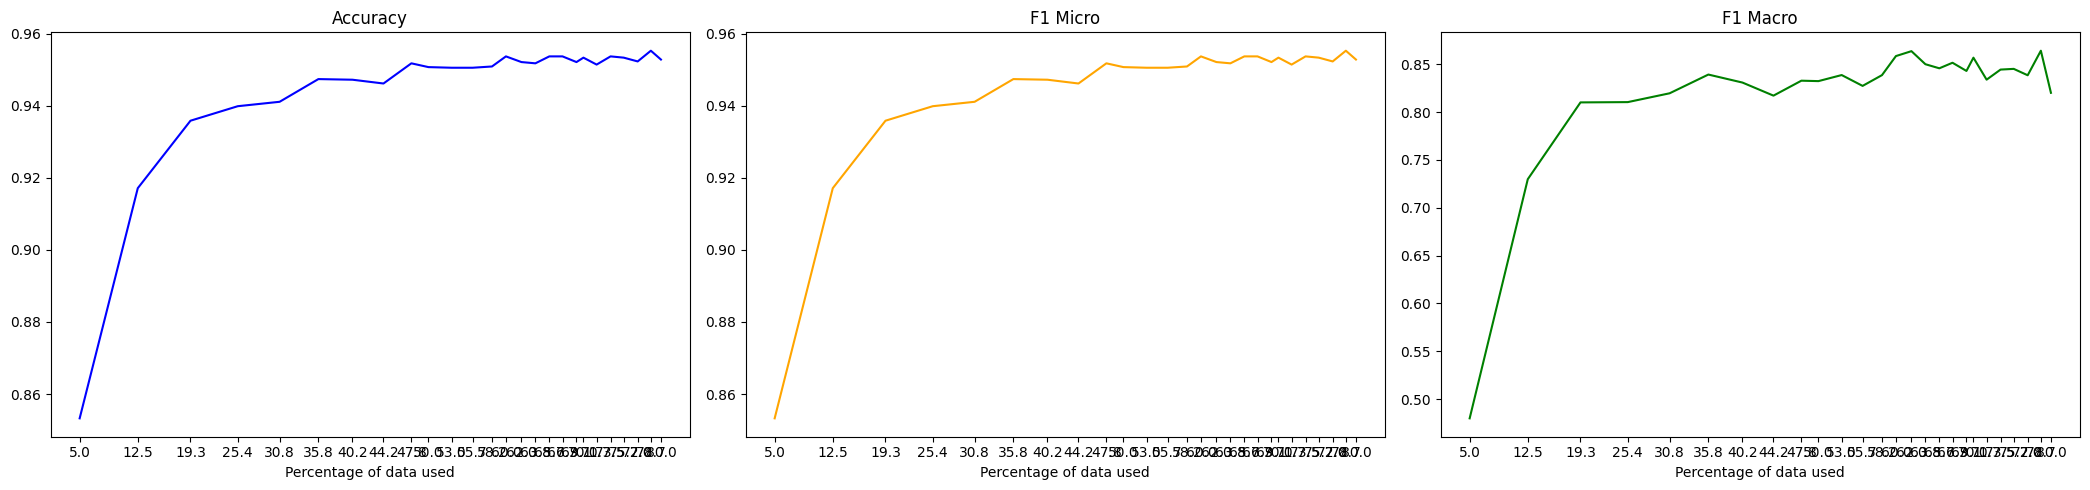

In [ ]:
active_learning(seeds[3], 3)

## RUN 5

TRIAL 5
Random seed: 94
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

EPOCH 1 | LOSS: 3.835564613342285 | ACCURACY: 0.8035 | F1 MACRO: 0.8853 | F1 MICRO: 0.8904
EPOCH 2 | LOSS: 3.432081937789917 | ACCURACY: 0.8056 | F1 MACRO: 0.8802 | F1 MICRO: 0.8894
EPOCH 3 | LOSS: 3.4125442504882812 | ACCURACY: 0.8043 | F1 MACRO: 0.8708 | F1 MICRO: 0.8869
EPOCH 4 | LOSS: 3.1747360229492188 | ACCURACY: 0.8134 | F1 MACRO: 0.8822 | F1 MICRO: 0.893
EPOCH 5 | LOSS: 2.9233813285827637 | ACCURACY: 0.8175 | F1 MACRO: 0.8858 | F1 MICRO: 0.8954
EPOCH 6 | LOSS: 2.7920596599578857 | ACCURACY: 0.8262 | F1 MACRO: 0.8899 | F1 MICRO: 0.8997
EPOCH 7 | LOSS: 2.7540390491485596 | ACCURACY: 0.8339 | F1 MACRO: 0.8977 | F1 MICRO: 0.9045
EPOCH 8 | LOSS: 2.6544532775878906 | ACCURACY: 0.8446 | F1 MACRO: 0.9017 | F1 MICRO: 0.9094
EPOCH 9 | LOSS: 2.619699478149414 | ACCURACY: 0.853 | F1 MACRO: 0.9069 | F1 MICRO: 0.9141
EPOCH 10 | LOSS: 2.61234974861145 | ACCURACY: 0.8583 | F1 MACRO: 0.9105 | F1 MICRO: 0.9169
aspect: ACCURACY 0.8583 | F1 MACRO 0.9105 | F1 MICRO 0.9169
              precision   

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 3.3163466453552246 | ACCURACY: 0.8082 | F1 MACRO: 0.8824 | F1 MICRO: 0.8909
EPOCH 2 | LOSS: 2.855426788330078 | ACCURACY: 0.8229 | F1 MACRO: 0.891 | F1 MICRO: 0.8982
EPOCH 3 | LOSS: 2.53902268409729 | ACCURACY: 0.8318 | F1 MACRO: 0.896 | F1 MICRO: 0.9034
EPOCH 4 | LOSS: 2.49914288520813 | ACCURACY: 0.8639 | F1 MACRO: 0.915 | F1 MICRO: 0.9203
EPOCH 5 | LOSS: 2.524113893508911 | ACCURACY: 0.8882 | F1 MACRO: 0.9296 | F1 MICRO: 0.9339
EPOCH 6 | LOSS: 2.3882434368133545 | ACCURACY: 0.9035 | F1 MACRO: 0.9389 | F1 MICRO: 0.9424
EPOCH 7 | LOSS: 2.360804557800293 | ACCURACY: 0.9186 | F1 MACRO: 0.9479 | F1 MICRO: 0.9509
EPOCH 8 | LOSS: 2.2304065227508545 | ACCURACY: 0.92 | F1 MACRO: 0.9485 | F1 MICRO: 0.9516
EPOCH 9 | LOSS: 2.1670868396759033 | ACCURACY: 0.9222 | F1 MACRO: 0.9492 | F1 MICRO: 0.9528
EPOCH 10 | LOSS: 2.095147132873535 | ACCURACY: 0.9278 | F1 MACRO: 0.9525 | F1 MICRO: 0.9559
aspect: ACCURACY 0.9278 | F1 MACRO 0.9525 | F1 MICRO 0.9559
              precision    recal

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 25.067739486694336 | ACCURACY: 0.8574 | F1 MACRO: 0.8106 | F1 MICRO: 0.8574
EPOCH 2 | LOSS: 20.777624130249023 | ACCURACY: 0.8543 | F1 MACRO: 0.791 | F1 MICRO: 0.8543
EPOCH 3 | LOSS: 19.517305374145508 | ACCURACY: 0.8783 | F1 MACRO: 0.8364 | F1 MICRO: 0.8783
EPOCH 4 | LOSS: 18.165300369262695 | ACCURACY: 0.8814 | F1 MACRO: 0.8494 | F1 MICRO: 0.8814
EPOCH 5 | LOSS: 17.51865577697754 | ACCURACY: 0.8866 | F1 MACRO: 0.8517 | F1 MICRO: 0.8866
EPOCH 6 | LOSS: 16.927135467529297 | ACCURACY: 0.8876 | F1 MACRO: 0.8496 | F1 MICRO: 0.8876
EPOCH 7 | LOSS: 15.887893676757812 | ACCURACY: 0.8668 | F1 MACRO: 0.8348 | F1 MICRO: 0.8668
EPOCH 8 | LOSS: 15.754600524902344 | ACCURACY: 0.8928 | F1 MACRO: 0.8627 | F1 MICRO: 0.8928
EPOCH 9 | LOSS: 15.124321937561035 | ACCURACY: 0.8907 | F1 MACRO: 0.8548 | F1 MICRO: 0.8907
EPOCH 10 | LOSS: 15.037806510925293 | ACCURACY: 0.8887 | F1 MACRO: 0.8533 | F1 MICRO: 0.8887
sentiment: ACCURACY 0.8928 | F1 MACRO 0.8627 | F1 MICRO 0.8928
              prec

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 3.1839709281921387 | ACCURACY: 0.8068 | F1 MACRO: 0.887 | F1 MICRO: 0.892
EPOCH 2 | LOSS: 2.574232816696167 | ACCURACY: 0.8436 | F1 MACRO: 0.8998 | F1 MICRO: 0.9088
EPOCH 3 | LOSS: 2.500081777572632 | ACCURACY: 0.8785 | F1 MACRO: 0.9232 | F1 MICRO: 0.9283
EPOCH 4 | LOSS: 2.4622185230255127 | ACCURACY: 0.903 | F1 MACRO: 0.9368 | F1 MICRO: 0.9415
EPOCH 5 | LOSS: 2.3742384910583496 | ACCURACY: 0.9262 | F1 MACRO: 0.9519 | F1 MICRO: 0.9551
EPOCH 6 | LOSS: 2.170081853866577 | ACCURACY: 0.9328 | F1 MACRO: 0.9554 | F1 MICRO: 0.959
EPOCH 7 | LOSS: 2.0839786529541016 | ACCURACY: 0.938 | F1 MACRO: 0.9586 | F1 MICRO: 0.9619
EPOCH 8 | LOSS: 2.0160067081451416 | ACCURACY: 0.9356 | F1 MACRO: 0.957 | F1 MICRO: 0.9602
EPOCH 9 | LOSS: 1.9411758184432983 | ACCURACY: 0.9411 | F1 MACRO: 0.9603 | F1 MICRO: 0.9636
EPOCH 10 | LOSS: 1.9230225086212158 | ACCURACY: 0.9446 | F1 MACRO: 0.9626 | F1 MICRO: 0.9658
aspect: ACCURACY 0.9446 | F1 MACRO 0.9626 | F1 MICRO 0.9658
              precision    r

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 18.315288543701172 | ACCURACY: 0.8229 | F1 MACRO: 0.7503 | F1 MICRO: 0.8229
EPOCH 2 | LOSS: 14.82442855834961 | ACCURACY: 0.8705 | F1 MACRO: 0.8329 | F1 MICRO: 0.8705
EPOCH 3 | LOSS: 14.042439460754395 | ACCURACY: 0.86 | F1 MACRO: 0.8187 | F1 MICRO: 0.86
EPOCH 4 | LOSS: 13.431058883666992 | ACCURACY: 0.8724 | F1 MACRO: 0.8353 | F1 MICRO: 0.8724
EPOCH 5 | LOSS: 12.91248893737793 | ACCURACY: 0.881 | F1 MACRO: 0.856 | F1 MICRO: 0.881
EPOCH 6 | LOSS: 12.208338737487793 | ACCURACY: 0.8943 | F1 MACRO: 0.8704 | F1 MICRO: 0.8943
EPOCH 7 | LOSS: 11.832072257995605 | ACCURACY: 0.8895 | F1 MACRO: 0.8668 | F1 MICRO: 0.8895
EPOCH 8 | LOSS: 11.427027702331543 | ACCURACY: 0.8962 | F1 MACRO: 0.8722 | F1 MICRO: 0.8962
EPOCH 9 | LOSS: 11.015480041503906 | ACCURACY: 0.8914 | F1 MACRO: 0.8688 | F1 MICRO: 0.8914
EPOCH 10 | LOSS: 10.645242691040039 | ACCURACY: 0.8848 | F1 MACRO: 0.8601 | F1 MICRO: 0.8848
sentiment: ACCURACY 0.8962 | F1 MACRO 0.8722 | F1 MICRO 0.8962
              precision  

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 2.977027177810669 | ACCURACY: 0.8179 | F1 MACRO: 0.8911 | F1 MICRO: 0.8968
EPOCH 2 | LOSS: 2.4030611515045166 | ACCURACY: 0.8611 | F1 MACRO: 0.9143 | F1 MICRO: 0.9192
EPOCH 3 | LOSS: 2.4247827529907227 | ACCURACY: 0.8981 | F1 MACRO: 0.9347 | F1 MICRO: 0.939
EPOCH 4 | LOSS: 2.3276731967926025 | ACCURACY: 0.9227 | F1 MACRO: 0.9495 | F1 MICRO: 0.9531
EPOCH 5 | LOSS: 2.1411972045898438 | ACCURACY: 0.9222 | F1 MACRO: 0.9494 | F1 MICRO: 0.9527
EPOCH 6 | LOSS: 2.0031943321228027 | ACCURACY: 0.9413 | F1 MACRO: 0.9612 | F1 MICRO: 0.9639
EPOCH 7 | LOSS: 1.9649391174316406 | ACCURACY: 0.9391 | F1 MACRO: 0.96 | F1 MICRO: 0.9627
EPOCH 8 | LOSS: 1.8884212970733643 | ACCURACY: 0.9432 | F1 MACRO: 0.962 | F1 MICRO: 0.9651
EPOCH 9 | LOSS: 1.803669810295105 | ACCURACY: 0.9451 | F1 MACRO: 0.9624 | F1 MICRO: 0.9661
EPOCH 10 | LOSS: 1.7660363912582397 | ACCURACY: 0.9488 | F1 MACRO: 0.9656 | F1 MICRO: 0.9684
aspect: ACCURACY 0.9488 | F1 MACRO 0.9656 | F1 MICRO 0.9684
              precision  

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 13.764498710632324 | ACCURACY: 0.8585 | F1 MACRO: 0.8267 | F1 MICRO: 0.8585
EPOCH 2 | LOSS: 11.10478401184082 | ACCURACY: 0.8872 | F1 MACRO: 0.8577 | F1 MICRO: 0.8872
EPOCH 3 | LOSS: 10.412342071533203 | ACCURACY: 0.8996 | F1 MACRO: 0.8706 | F1 MICRO: 0.8996
EPOCH 4 | LOSS: 9.983698844909668 | ACCURACY: 0.8987 | F1 MACRO: 0.8705 | F1 MICRO: 0.8987
EPOCH 5 | LOSS: 9.581682205200195 | ACCURACY: 0.8891 | F1 MACRO: 0.867 | F1 MICRO: 0.8891
EPOCH 6 | LOSS: 9.13205337524414 | ACCURACY: 0.9063 | F1 MACRO: 0.8794 | F1 MICRO: 0.9063
EPOCH 7 | LOSS: 8.658928871154785 | ACCURACY: 0.9044 | F1 MACRO: 0.8792 | F1 MICRO: 0.9044
EPOCH 8 | LOSS: 8.665273666381836 | ACCURACY: 0.9006 | F1 MACRO: 0.8714 | F1 MICRO: 0.9006
EPOCH 9 | LOSS: 8.278951644897461 | ACCURACY: 0.8939 | F1 MACRO: 0.8699 | F1 MICRO: 0.8939
in second
EPOCH 10 | LOSS: 7.6857805252075195 | ACCURACY: 0.9092 | F1 MACRO: 0.8873 | F1 MICRO: 0.9092
sentiment: ACCURACY 0.9063 | F1 MACRO 0.8794 | F1 MICRO 0.9063
              p

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 2.9405081272125244 | ACCURACY: 0.8227 | F1 MACRO: 0.8942 | F1 MICRO: 0.8997
EPOCH 2 | LOSS: 2.4452719688415527 | ACCURACY: 0.8766 | F1 MACRO: 0.9228 | F1 MICRO: 0.9274
EPOCH 3 | LOSS: 2.3306143283843994 | ACCURACY: 0.9205 | F1 MACRO: 0.9471 | F1 MICRO: 0.9517
EPOCH 4 | LOSS: 2.1538078784942627 | ACCURACY: 0.9335 | F1 MACRO: 0.9562 | F1 MICRO: 0.9594
EPOCH 5 | LOSS: 2.040520668029785 | ACCURACY: 0.9422 | F1 MACRO: 0.9621 | F1 MICRO: 0.9646
EPOCH 6 | LOSS: 1.932385802268982 | ACCURACY: 0.9464 | F1 MACRO: 0.964 | F1 MICRO: 0.9669
EPOCH 7 | LOSS: 1.861721158027649 | ACCURACY: 0.9427 | F1 MACRO: 0.9614 | F1 MICRO: 0.9648
EPOCH 8 | LOSS: 1.8167797327041626 | ACCURACY: 0.946 | F1 MACRO: 0.9634 | F1 MICRO: 0.9666
EPOCH 9 | LOSS: 1.785086750984192 | ACCURACY: 0.947 | F1 MACRO: 0.9647 | F1 MICRO: 0.9673
EPOCH 10 | LOSS: 1.7343891859054565 | ACCURACY: 0.9497 | F1 MACRO: 0.966 | F1 MICRO: 0.9689
aspect: ACCURACY 0.9497 | F1 MACRO 0.966 | F1 MICRO 0.9689
              precision    r

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 11.465964317321777 | ACCURACY: 0.8373 | F1 MACRO: 0.803 | F1 MICRO: 0.8373
EPOCH 2 | LOSS: 9.790767669677734 | ACCURACY: 0.8586 | F1 MACRO: 0.8076 | F1 MICRO: 0.8586
EPOCH 3 | LOSS: 8.962854385375977 | ACCURACY: 0.8826 | F1 MACRO: 0.8528 | F1 MICRO: 0.8826
EPOCH 4 | LOSS: 8.623152732849121 | ACCURACY: 0.8826 | F1 MACRO: 0.8465 | F1 MICRO: 0.8826
EPOCH 5 | LOSS: 8.18477725982666 | ACCURACY: 0.8845 | F1 MACRO: 0.851 | F1 MICRO: 0.8845
EPOCH 6 | LOSS: 7.978300094604492 | ACCURACY: 0.8909 | F1 MACRO: 0.8661 | F1 MICRO: 0.8909
EPOCH 7 | LOSS: 7.575878143310547 | ACCURACY: 0.8965 | F1 MACRO: 0.8722 | F1 MICRO: 0.8965
EPOCH 8 | LOSS: 7.185144901275635 | ACCURACY: 0.89 | F1 MACRO: 0.8679 | F1 MICRO: 0.89
EPOCH 9 | LOSS: nan | ACCURACY: 0.6978 | F1 MACRO: 0.411 | F1 MICRO: 0.6978
EPOCH 10 | LOSS: nan | ACCURACY: 0.6978 | F1 MACRO: 0.411 | F1 MICRO: 0.6978
sentiment: ACCURACY 0.8965 | F1 MACRO 0.8722 | F1 MICRO 0.8965
              precision    recall  f1-score   support

    neg

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 10.190558433532715 | ACCURACY: 0.8376 | F1 MACRO: 0.797 | F1 MICRO: 0.8376
EPOCH 2 | LOSS: 8.320051193237305 | ACCURACY: 0.8685 | F1 MACRO: 0.821 | F1 MICRO: 0.8685
EPOCH 3 | LOSS: 7.397939682006836 | ACCURACY: 0.8873 | F1 MACRO: 0.8512 | F1 MICRO: 0.8873
EPOCH 4 | LOSS: 7.173997402191162 | ACCURACY: 0.8967 | F1 MACRO: 0.8683 | F1 MICRO: 0.8967
EPOCH 5 | LOSS: 6.854794025421143 | ACCURACY: 0.8995 | F1 MACRO: 0.8717 | F1 MICRO: 0.8995
EPOCH 6 | LOSS: 6.688007354736328 | ACCURACY: 0.8967 | F1 MACRO: 0.8668 | F1 MICRO: 0.8967
EPOCH 7 | LOSS: 6.349958896636963 | ACCURACY: 0.9014 | F1 MACRO: 0.8744 | F1 MICRO: 0.9014
EPOCH 8 | LOSS: 6.077341079711914 | ACCURACY: 0.8967 | F1 MACRO: 0.8708 | F1 MICRO: 0.8967
EPOCH 9 | LOSS: 5.9291558265686035 | ACCURACY: 0.8864 | F1 MACRO: 0.8539 | F1 MICRO: 0.8864
EPOCH 10 | LOSS: 5.896709442138672 | ACCURACY: 0.9005 | F1 MACRO: 0.8713 | F1 MICRO: 0.9005
sentiment: ACCURACY 0.9014 | F1 MACRO 0.8744 | F1 MICRO 0.9014
              precision   

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 2.7760536670684814 | ACCURACY: 0.8427 | F1 MACRO: 0.9036 | F1 MICRO: 0.9095
EPOCH 2 | LOSS: 2.3915226459503174 | ACCURACY: 0.905 | F1 MACRO: 0.9399 | F1 MICRO: 0.9432
EPOCH 3 | LOSS: 2.2000319957733154 | ACCURACY: 0.9344 | F1 MACRO: 0.9564 | F1 MICRO: 0.9597
EPOCH 4 | LOSS: 2.0277509689331055 | ACCURACY: 0.9415 | F1 MACRO: 0.9614 | F1 MICRO: 0.9642
EPOCH 5 | LOSS: 1.9129812717437744 | ACCURACY: 0.9505 | F1 MACRO: 0.9665 | F1 MICRO: 0.9694
EPOCH 6 | LOSS: 1.8247621059417725 | ACCURACY: 0.9524 | F1 MACRO: 0.9677 | F1 MICRO: 0.9705
EPOCH 7 | LOSS: 1.7856687307357788 | ACCURACY: 0.9542 | F1 MACRO: 0.9687 | F1 MICRO: 0.9716
EPOCH 8 | LOSS: 1.71983003616333 | ACCURACY: 0.9495 | F1 MACRO: 0.9658 | F1 MICRO: 0.9689
EPOCH 9 | LOSS: 1.6898523569107056 | ACCURACY: 0.9531 | F1 MACRO: 0.9682 | F1 MICRO: 0.9711
EPOCH 10 | LOSS: 1.6369723081588745 | ACCURACY: 0.9545 | F1 MACRO: 0.9689 | F1 MICRO: 0.9717
aspect: ACCURACY 0.9545 | F1 MACRO 0.9689 | F1 MICRO 0.9717
              precisio

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 8.911020278930664 | ACCURACY: 0.8451 | F1 MACRO: 0.7875 | F1 MICRO: 0.8451
EPOCH 2 | LOSS: 7.257819175720215 | ACCURACY: 0.8678 | F1 MACRO: 0.8293 | F1 MICRO: 0.8678
EPOCH 3 | LOSS: 6.80073881149292 | ACCURACY: 0.8804 | F1 MACRO: 0.8514 | F1 MICRO: 0.8804
EPOCH 4 | LOSS: 6.490038871765137 | ACCURACY: 0.8813 | F1 MACRO: 0.8453 | F1 MICRO: 0.8813
EPOCH 5 | LOSS: 6.3165507316589355 | ACCURACY: 0.8777 | F1 MACRO: 0.8402 | F1 MICRO: 0.8777
EPOCH 6 | LOSS: 6.01087760925293 | ACCURACY: 0.8913 | F1 MACRO: 0.8633 | F1 MICRO: 0.8913
EPOCH 7 | LOSS: 5.822183609008789 | ACCURACY: 0.8813 | F1 MACRO: 0.8524 | F1 MICRO: 0.8813
EPOCH 8 | LOSS: 5.559112071990967 | ACCURACY: 0.885 | F1 MACRO: 0.8554 | F1 MICRO: 0.885
EPOCH 9 | LOSS: 5.439971923828125 | ACCURACY: 0.8841 | F1 MACRO: 0.8532 | F1 MICRO: 0.8841
in second
EPOCH 10 | LOSS: 4.982216835021973 | ACCURACY: 0.8904 | F1 MACRO: 0.8634 | F1 MICRO: 0.8904
sentiment: ACCURACY 0.8913 | F1 MACRO 0.8633 | F1 MICRO 0.8913
              preci

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 7.6912150382995605 | ACCURACY: 0.8414 | F1 MACRO: 0.7703 | F1 MICRO: 0.8414
EPOCH 2 | LOSS: 6.086164951324463 | ACCURACY: 0.8955 | F1 MACRO: 0.8671 | F1 MICRO: 0.8955
EPOCH 3 | LOSS: 5.632586479187012 | ACCURACY: 0.8946 | F1 MACRO: 0.8629 | F1 MICRO: 0.8946
EPOCH 4 | LOSS: 5.446618556976318 | ACCURACY: 0.8908 | F1 MACRO: 0.853 | F1 MICRO: 0.8908
EPOCH 5 | LOSS: 5.268673896789551 | ACCURACY: 0.8965 | F1 MACRO: 0.8648 | F1 MICRO: 0.8965
EPOCH 6 | LOSS: 5.147680282592773 | ACCURACY: 0.9079 | F1 MACRO: 0.8827 | F1 MICRO: 0.9079
EPOCH 7 | LOSS: 4.968920707702637 | ACCURACY: 0.9031 | F1 MACRO: 0.8784 | F1 MICRO: 0.9031
EPOCH 8 | LOSS: 4.877697467803955 | ACCURACY: 0.8974 | F1 MACRO: 0.8692 | F1 MICRO: 0.8974
EPOCH 9 | LOSS: 4.780863285064697 | ACCURACY: 0.8993 | F1 MACRO: 0.8714 | F1 MICRO: 0.8993
in second
EPOCH 10 | LOSS: 4.406444549560547 | ACCURACY: 0.8974 | F1 MACRO: 0.8695 | F1 MICRO: 0.8974
sentiment: ACCURACY 0.9079 | F1 MACRO 0.8827 | F1 MICRO 0.9079
              pr

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 2.7266812324523926 | ACCURACY: 0.8599 | F1 MACRO: 0.9101 | F1 MICRO: 0.9173
EPOCH 2 | LOSS: 2.3773534297943115 | ACCURACY: 0.9226 | F1 MACRO: 0.9499 | F1 MICRO: 0.9532
EPOCH 3 | LOSS: 2.102503538131714 | ACCURACY: 0.9373 | F1 MACRO: 0.9583 | F1 MICRO: 0.9616
EPOCH 4 | LOSS: 1.9987308979034424 | ACCURACY: 0.9469 | F1 MACRO: 0.9647 | F1 MICRO: 0.9673
EPOCH 5 | LOSS: 1.861864686012268 | ACCURACY: 0.9542 | F1 MACRO: 0.9693 | F1 MICRO: 0.9717
EPOCH 6 | LOSS: 1.7980608940124512 | ACCURACY: 0.9531 | F1 MACRO: 0.968 | F1 MICRO: 0.971
EPOCH 7 | LOSS: 1.738912582397461 | ACCURACY: 0.9564 | F1 MACRO: 0.9703 | F1 MICRO: 0.973
EPOCH 8 | LOSS: 1.6860653162002563 | ACCURACY: 0.9568 | F1 MACRO: 0.9707 | F1 MICRO: 0.9732
EPOCH 9 | LOSS: 1.6484309434890747 | ACCURACY: 0.9561 | F1 MACRO: 0.9699 | F1 MICRO: 0.9727
EPOCH 10 | LOSS: 1.6042429208755493 | ACCURACY: 0.9561 | F1 MACRO: 0.9702 | F1 MICRO: 0.9727
aspect: ACCURACY 0.9568 | F1 MACRO 0.9707 | F1 MICRO 0.9732
              precision  

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 7.307619094848633 | ACCURACY: 0.8604 | F1 MACRO: 0.8132 | F1 MICRO: 0.8604
EPOCH 2 | LOSS: 6.062886714935303 | ACCURACY: 0.8768 | F1 MACRO: 0.8364 | F1 MICRO: 0.8768
EPOCH 3 | LOSS: 5.650987148284912 | ACCURACY: 0.8951 | F1 MACRO: 0.8665 | F1 MICRO: 0.8951
EPOCH 4 | LOSS: 5.363502502441406 | ACCURACY: 0.8996 | F1 MACRO: 0.8735 | F1 MICRO: 0.8996
EPOCH 5 | LOSS: 5.086329460144043 | ACCURACY: 0.906 | F1 MACRO: 0.8802 | F1 MICRO: 0.906
EPOCH 6 | LOSS: 4.9285407066345215 | ACCURACY: 0.8869 | F1 MACRO: 0.8488 | F1 MICRO: 0.8869
EPOCH 7 | LOSS: 4.821609020233154 | ACCURACY: 0.8996 | F1 MACRO: 0.869 | F1 MICRO: 0.8996
EPOCH 8 | LOSS: 4.596200466156006 | ACCURACY: 0.8996 | F1 MACRO: 0.8724 | F1 MICRO: 0.8996
in second
EPOCH 9 | LOSS: 4.197989463806152 | ACCURACY: 0.9024 | F1 MACRO: 0.8753 | F1 MICRO: 0.9024
in second
EPOCH 10 | LOSS: 4.166971683502197 | ACCURACY: 0.9005 | F1 MACRO: 0.8743 | F1 MICRO: 0.9005
sentiment: ACCURACY 0.906 | F1 MACRO 0.8802 | F1 MICRO 0.906
          

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 6.659102439880371 | ACCURACY: 0.8385 | F1 MACRO: 0.7828 | F1 MICRO: 0.8385
EPOCH 2 | LOSS: 5.5714192390441895 | ACCURACY: 0.8778 | F1 MACRO: 0.8471 | F1 MICRO: 0.8778
EPOCH 3 | LOSS: 5.263741970062256 | ACCURACY: 0.8822 | F1 MACRO: 0.8485 | F1 MICRO: 0.8822
EPOCH 4 | LOSS: 4.973216533660889 | ACCURACY: 0.8822 | F1 MACRO: 0.8472 | F1 MICRO: 0.8822
EPOCH 5 | LOSS: 4.809734344482422 | ACCURACY: 0.8885 | F1 MACRO: 0.8588 | F1 MICRO: 0.8885
EPOCH 6 | LOSS: 4.590072154998779 | ACCURACY: 0.8822 | F1 MACRO: 0.8511 | F1 MICRO: 0.8822
EPOCH 7 | LOSS: 4.491551399230957 | ACCURACY: 0.8849 | F1 MACRO: 0.8502 | F1 MICRO: 0.8849
EPOCH 8 | LOSS: 4.256178379058838 | ACCURACY: 0.8858 | F1 MACRO: 0.8544 | F1 MICRO: 0.8858
in second
EPOCH 9 | LOSS: 3.876796245574951 | ACCURACY: 0.8894 | F1 MACRO: 0.8609 | F1 MICRO: 0.8894
in second
EPOCH 10 | LOSS: 3.8573660850524902 | ACCURACY: 0.8921 | F1 MACRO: 0.8633 | F1 MICRO: 0.8921
sentiment: ACCURACY 0.8885 | F1 MACRO 0.8588 | F1 MICRO 0.8885
    

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 6.170694828033447 | ACCURACY: 0.8419 | F1 MACRO: 0.7958 | F1 MICRO: 0.8419
EPOCH 2 | LOSS: 5.038221836090088 | ACCURACY: 0.8799 | F1 MACRO: 0.8434 | F1 MICRO: 0.8799
EPOCH 3 | LOSS: 4.69219446182251 | ACCURACY: 0.8916 | F1 MACRO: 0.8637 | F1 MICRO: 0.8916
EPOCH 4 | LOSS: 4.5162177085876465 | ACCURACY: 0.8898 | F1 MACRO: 0.8565 | F1 MICRO: 0.8898
EPOCH 5 | LOSS: 4.325767517089844 | ACCURACY: 0.8889 | F1 MACRO: 0.8565 | F1 MICRO: 0.8889
EPOCH 6 | LOSS: 4.220763683319092 | ACCURACY: 0.8916 | F1 MACRO: 0.8595 | F1 MICRO: 0.8916
EPOCH 7 | LOSS: 4.037106037139893 | ACCURACY: 0.8853 | F1 MACRO: 0.8518 | F1 MICRO: 0.8853
EPOCH 8 | LOSS: 3.954115629196167 | ACCURACY: 0.8889 | F1 MACRO: 0.8629 | F1 MICRO: 0.8889
EPOCH 9 | LOSS: 3.8591482639312744 | ACCURACY: 0.8934 | F1 MACRO: 0.8625 | F1 MICRO: 0.8934
EPOCH 10 | LOSS: 3.8784279823303223 | ACCURACY: 0.8889 | F1 MACRO: 0.8562 | F1 MICRO: 0.8889
sentiment: ACCURACY 0.8934 | F1 MACRO 0.8625 | F1 MICRO 0.8934
              precision 

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 6.2094407081604 | ACCURACY: 0.8694 | F1 MACRO: 0.8325 | F1 MICRO: 0.8694
EPOCH 2 | LOSS: 4.826869487762451 | ACCURACY: 0.8972 | F1 MACRO: 0.869 | F1 MICRO: 0.8972
EPOCH 3 | LOSS: 4.4718546867370605 | ACCURACY: 0.8963 | F1 MACRO: 0.8686 | F1 MICRO: 0.8963
EPOCH 4 | LOSS: 4.261879920959473 | ACCURACY: 0.9009 | F1 MACRO: 0.8754 | F1 MICRO: 0.9009
EPOCH 5 | LOSS: 4.089796543121338 | ACCURACY: 0.9019 | F1 MACRO: 0.8737 | F1 MICRO: 0.9019
EPOCH 6 | LOSS: 3.920236110687256 | ACCURACY: 0.9046 | F1 MACRO: 0.8782 | F1 MICRO: 0.9046
EPOCH 7 | LOSS: 3.854963779449463 | ACCURACY: 0.8963 | F1 MACRO: 0.871 | F1 MICRO: 0.8963
EPOCH 8 | LOSS: 3.730102300643921 | ACCURACY: 0.8991 | F1 MACRO: 0.8694 | F1 MICRO: 0.8991
EPOCH 9 | LOSS: 3.6922826766967773 | ACCURACY: 0.8852 | F1 MACRO: 0.848 | F1 MICRO: 0.8852
in second
EPOCH 10 | LOSS: 3.4688878059387207 | ACCURACY: 0.9019 | F1 MACRO: 0.8748 | F1 MICRO: 0.9019
sentiment: ACCURACY 0.9046 | F1 MACRO 0.8782 | F1 MICRO 0.9046
              prec

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 2.648345470428467 | ACCURACY: 0.8807 | F1 MACRO: 0.9246 | F1 MICRO: 0.9295
EPOCH 2 | LOSS: 2.2710909843444824 | ACCURACY: 0.9365 | F1 MACRO: 0.9584 | F1 MICRO: 0.9611
EPOCH 3 | LOSS: 2.0102450847625732 | ACCURACY: 0.9427 | F1 MACRO: 0.962 | F1 MICRO: 0.9648
EPOCH 4 | LOSS: 1.8900164365768433 | ACCURACY: 0.9469 | F1 MACRO: 0.9643 | F1 MICRO: 0.9674
EPOCH 5 | LOSS: 1.8064290285110474 | ACCURACY: 0.9516 | F1 MACRO: 0.9676 | F1 MICRO: 0.9701
EPOCH 6 | LOSS: 1.7376859188079834 | ACCURACY: 0.9556 | F1 MACRO: 0.9696 | F1 MICRO: 0.9724
EPOCH 7 | LOSS: 1.6838204860687256 | ACCURACY: 0.9594 | F1 MACRO: 0.9723 | F1 MICRO: 0.9748
EPOCH 8 | LOSS: 1.6302883625030518 | ACCURACY: 0.9585 | F1 MACRO: 0.9714 | F1 MICRO: 0.9741
EPOCH 9 | LOSS: 1.6100260019302368 | ACCURACY: 0.9545 | F1 MACRO: 0.9693 | F1 MICRO: 0.9719
EPOCH 10 | LOSS: 1.5747976303100586 | ACCURACY: 0.9576 | F1 MACRO: 0.9711 | F1 MICRO: 0.9737
aspect: ACCURACY 0.9594 | F1 MACRO 0.9723 | F1 MICRO 0.9748
              precisi

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 5.896153926849365 | ACCURACY: 0.8616 | F1 MACRO: 0.8227 | F1 MICRO: 0.8616
EPOCH 2 | LOSS: 4.722757816314697 | ACCURACY: 0.8718 | F1 MACRO: 0.8239 | F1 MICRO: 0.8718
EPOCH 3 | LOSS: 4.34565544128418 | ACCURACY: 0.8976 | F1 MACRO: 0.8698 | F1 MICRO: 0.8976
EPOCH 4 | LOSS: 4.173527717590332 | ACCURACY: 0.8976 | F1 MACRO: 0.8703 | F1 MICRO: 0.8976
EPOCH 5 | LOSS: 3.978321075439453 | ACCURACY: 0.8948 | F1 MACRO: 0.8631 | F1 MICRO: 0.8948
EPOCH 6 | LOSS: 3.887418508529663 | ACCURACY: 0.905 | F1 MACRO: 0.8792 | F1 MICRO: 0.905
EPOCH 7 | LOSS: 3.755491256713867 | ACCURACY: 0.9013 | F1 MACRO: 0.8737 | F1 MICRO: 0.9013
EPOCH 8 | LOSS: 3.677454948425293 | ACCURACY: 0.9022 | F1 MACRO: 0.8752 | F1 MICRO: 0.9022
EPOCH 9 | LOSS: 3.5987796783447266 | ACCURACY: 0.9004 | F1 MACRO: 0.8734 | F1 MICRO: 0.9004
in second
EPOCH 10 | LOSS: 3.3439383506774902 | ACCURACY: 0.8967 | F1 MACRO: 0.8699 | F1 MICRO: 0.8967
sentiment: ACCURACY 0.905 | F1 MACRO 0.8792 | F1 MICRO 0.905
              preci

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 5.638965129852295 | ACCURACY: 0.8689 | F1 MACRO: 0.8346 | F1 MICRO: 0.8689
EPOCH 2 | LOSS: 4.415597438812256 | ACCURACY: 0.8957 | F1 MACRO: 0.8628 | F1 MICRO: 0.8957
EPOCH 3 | LOSS: 4.122681140899658 | ACCURACY: 0.8901 | F1 MACRO: 0.863 | F1 MICRO: 0.8901
EPOCH 4 | LOSS: 3.937650442123413 | ACCURACY: 0.9049 | F1 MACRO: 0.8775 | F1 MICRO: 0.9049
EPOCH 5 | LOSS: 3.790776491165161 | ACCURACY: 0.8947 | F1 MACRO: 0.8675 | F1 MICRO: 0.8947
EPOCH 6 | LOSS: 3.6682045459747314 | ACCURACY: 0.9049 | F1 MACRO: 0.8781 | F1 MICRO: 0.9049
EPOCH 7 | LOSS: 3.6003901958465576 | ACCURACY: 0.9104 | F1 MACRO: 0.8833 | F1 MICRO: 0.9104
EPOCH 8 | LOSS: 3.5468108654022217 | ACCURACY: 0.9123 | F1 MACRO: 0.8857 | F1 MICRO: 0.9123
EPOCH 9 | LOSS: 3.452857255935669 | ACCURACY: 0.9049 | F1 MACRO: 0.8797 | F1 MICRO: 0.9049
EPOCH 10 | LOSS: 3.358142614364624 | ACCURACY: 0.9086 | F1 MACRO: 0.8841 | F1 MICRO: 0.9086
sentiment: ACCURACY 0.9123 | F1 MACRO 0.8857 | F1 MICRO 0.9123
              precision 

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 2.674060821533203 | ACCURACY: 0.8896 | F1 MACRO: 0.9291 | F1 MICRO: 0.934
EPOCH 2 | LOSS: 2.1848225593566895 | ACCURACY: 0.9332 | F1 MACRO: 0.9565 | F1 MICRO: 0.9592
EPOCH 3 | LOSS: 1.9661279916763306 | ACCURACY: 0.946 | F1 MACRO: 0.9642 | F1 MICRO: 0.9669
EPOCH 4 | LOSS: 1.858236312866211 | ACCURACY: 0.9512 | F1 MACRO: 0.9672 | F1 MICRO: 0.9699
EPOCH 5 | LOSS: 1.7608901262283325 | ACCURACY: 0.9523 | F1 MACRO: 0.9682 | F1 MICRO: 0.9706
EPOCH 6 | LOSS: 1.7131725549697876 | ACCURACY: 0.9568 | F1 MACRO: 0.9708 | F1 MICRO: 0.9732
EPOCH 7 | LOSS: 1.6621836423873901 | ACCURACY: 0.958 | F1 MACRO: 0.9716 | F1 MICRO: 0.9739
EPOCH 8 | LOSS: 1.6136205196380615 | ACCURACY: 0.9589 | F1 MACRO: 0.972 | F1 MICRO: 0.9744
EPOCH 9 | LOSS: 1.5746034383773804 | ACCURACY: 0.9589 | F1 MACRO: 0.9722 | F1 MICRO: 0.9744
EPOCH 10 | LOSS: 1.55048406124115 | ACCURACY: 0.9592 | F1 MACRO: 0.9722 | F1 MICRO: 0.9747
aspect: ACCURACY 0.9592 | F1 MACRO 0.9722 | F1 MICRO 0.9747
              precision    

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 2.6428511142730713 | ACCURACY: 0.8858 | F1 MACRO: 0.9268 | F1 MICRO: 0.932
EPOCH 2 | LOSS: 2.2451305389404297 | ACCURACY: 0.9366 | F1 MACRO: 0.9579 | F1 MICRO: 0.9611
EPOCH 3 | LOSS: 2.003739356994629 | ACCURACY: 0.9497 | F1 MACRO: 0.9661 | F1 MICRO: 0.9689
EPOCH 4 | LOSS: 1.8618744611740112 | ACCURACY: 0.955 | F1 MACRO: 0.9697 | F1 MICRO: 0.9722
EPOCH 5 | LOSS: 1.7851585149765015 | ACCURACY: 0.9542 | F1 MACRO: 0.9689 | F1 MICRO: 0.9717
EPOCH 6 | LOSS: 1.7369157075881958 | ACCURACY: 0.9569 | F1 MACRO: 0.9709 | F1 MICRO: 0.9733
EPOCH 7 | LOSS: 1.6862870454788208 | ACCURACY: 0.9573 | F1 MACRO: 0.9709 | F1 MICRO: 0.9736
EPOCH 8 | LOSS: 1.6224480867385864 | ACCURACY: 0.958 | F1 MACRO: 0.972 | F1 MICRO: 0.974
EPOCH 9 | LOSS: 1.5911051034927368 | ACCURACY: 0.9582 | F1 MACRO: 0.9713 | F1 MICRO: 0.974
EPOCH 10 | LOSS: 1.5544712543487549 | ACCURACY: 0.9559 | F1 MACRO: 0.9702 | F1 MICRO: 0.9726
aspect: ACCURACY 0.958 | F1 MACRO 0.972 | F1 MICRO 0.974
              precision    re

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 2.666594982147217 | ACCURACY: 0.8889 | F1 MACRO: 0.9282 | F1 MICRO: 0.9336
EPOCH 2 | LOSS: 2.226292848587036 | ACCURACY: 0.941 | F1 MACRO: 0.9607 | F1 MICRO: 0.9638
EPOCH 3 | LOSS: 1.9760000705718994 | ACCURACY: 0.9462 | F1 MACRO: 0.9643 | F1 MICRO: 0.967
EPOCH 4 | LOSS: 1.8493455648422241 | ACCURACY: 0.9578 | F1 MACRO: 0.9709 | F1 MICRO: 0.9738
EPOCH 5 | LOSS: 1.7596688270568848 | ACCURACY: 0.9578 | F1 MACRO: 0.9709 | F1 MICRO: 0.9739
EPOCH 6 | LOSS: 1.7064573764801025 | ACCURACY: 0.9568 | F1 MACRO: 0.9705 | F1 MICRO: 0.9732
EPOCH 7 | LOSS: 1.674533724784851 | ACCURACY: 0.9556 | F1 MACRO: 0.9691 | F1 MICRO: 0.9723
EPOCH 8 | LOSS: 1.612133264541626 | ACCURACY: 0.9585 | F1 MACRO: 0.9718 | F1 MICRO: 0.9743
EPOCH 9 | LOSS: 1.5782123804092407 | ACCURACY: 0.9552 | F1 MACRO: 0.9699 | F1 MICRO: 0.9723
EPOCH 10 | LOSS: 1.5531094074249268 | ACCURACY: 0.9589 | F1 MACRO: 0.9721 | F1 MICRO: 0.9745
aspect: ACCURACY 0.9589 | F1 MACRO 0.9721 | F1 MICRO 0.9745
              precision  

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 5.143458843231201 | ACCURACY: 0.8359 | F1 MACRO: 0.7709 | F1 MICRO: 0.8359
EPOCH 2 | LOSS: 4.053491115570068 | ACCURACY: 0.8876 | F1 MACRO: 0.8584 | F1 MICRO: 0.8876
EPOCH 3 | LOSS: 3.716848850250244 | ACCURACY: 0.8965 | F1 MACRO: 0.8722 | F1 MICRO: 0.8965
EPOCH 4 | LOSS: 3.584131956100464 | ACCURACY: 0.8849 | F1 MACRO: 0.8528 | F1 MICRO: 0.8849
EPOCH 5 | LOSS: 3.4500279426574707 | ACCURACY: 0.8983 | F1 MACRO: 0.8732 | F1 MICRO: 0.8983
EPOCH 6 | LOSS: 3.260603427886963 | ACCURACY: 0.9037 | F1 MACRO: 0.8798 | F1 MICRO: 0.9037
EPOCH 7 | LOSS: 3.2071824073791504 | ACCURACY: 0.8992 | F1 MACRO: 0.8734 | F1 MICRO: 0.8992
EPOCH 8 | LOSS: 3.104870080947876 | ACCURACY: 0.8983 | F1 MACRO: 0.8739 | F1 MICRO: 0.8983
EPOCH 9 | LOSS: 3.0705323219299316 | ACCURACY: 0.8965 | F1 MACRO: 0.8717 | F1 MICRO: 0.8965
in second
EPOCH 10 | LOSS: 2.927877902984619 | ACCURACY: 0.8992 | F1 MACRO: 0.8754 | F1 MICRO: 0.8992
sentiment: ACCURACY 0.9037 | F1 MACRO 0.8798 | F1 MICRO 0.9037
             

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 4.866812229156494 | ACCURACY: 0.8513 | F1 MACRO: 0.8111 | F1 MICRO: 0.8513
EPOCH 2 | LOSS: 3.9317400455474854 | ACCURACY: 0.883 | F1 MACRO: 0.8462 | F1 MICRO: 0.883
EPOCH 3 | LOSS: 3.568455934524536 | ACCURACY: 0.8921 | F1 MACRO: 0.8616 | F1 MICRO: 0.8921
EPOCH 4 | LOSS: 3.481832265853882 | ACCURACY: 0.9003 | F1 MACRO: 0.873 | F1 MICRO: 0.9003
EPOCH 5 | LOSS: 3.2599241733551025 | ACCURACY: 0.8985 | F1 MACRO: 0.8675 | F1 MICRO: 0.8985
EPOCH 6 | LOSS: 3.1722517013549805 | ACCURACY: 0.8948 | F1 MACRO: 0.8667 | F1 MICRO: 0.8948
EPOCH 7 | LOSS: 3.1309404373168945 | ACCURACY: 0.8948 | F1 MACRO: 0.8634 | F1 MICRO: 0.8948
in second
EPOCH 8 | LOSS: 2.86972713470459 | ACCURACY: 0.9021 | F1 MACRO: 0.8742 | F1 MICRO: 0.9021
in second
EPOCH 9 | LOSS: 2.855220317840576 | ACCURACY: 0.9039 | F1 MACRO: 0.8768 | F1 MICRO: 0.9039
in second
EPOCH 10 | LOSS: 2.8430774211883545 | ACCURACY: 0.9039 | F1 MACRO: 0.8768 | F1 MICRO: 0.9039
sentiment: ACCURACY 0.9003 | F1 MACRO 0.873 | F1 MICRO 0.9

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 2.6157333850860596 | ACCURACY: 0.9082 | F1 MACRO: 0.9399 | F1 MICRO: 0.9446
EPOCH 2 | LOSS: 2.1688108444213867 | ACCURACY: 0.9408 | F1 MACRO: 0.9605 | F1 MICRO: 0.9637
EPOCH 3 | LOSS: 1.9314202070236206 | ACCURACY: 0.9503 | F1 MACRO: 0.9666 | F1 MICRO: 0.9695
EPOCH 4 | LOSS: 1.8149181604385376 | ACCURACY: 0.9542 | F1 MACRO: 0.9684 | F1 MICRO: 0.9716
EPOCH 5 | LOSS: 1.7412959337234497 | ACCURACY: 0.9578 | F1 MACRO: 0.9711 | F1 MICRO: 0.9738
EPOCH 6 | LOSS: 1.6938542127609253 | ACCURACY: 0.9542 | F1 MACRO: 0.9689 | F1 MICRO: 0.9717
EPOCH 7 | LOSS: 1.638074278831482 | ACCURACY: 0.9601 | F1 MACRO: 0.9728 | F1 MICRO: 0.9752
EPOCH 8 | LOSS: 1.6057548522949219 | ACCURACY: 0.9564 | F1 MACRO: 0.9707 | F1 MICRO: 0.9731
EPOCH 9 | LOSS: 1.558174729347229 | ACCURACY: 0.9609 | F1 MACRO: 0.9734 | F1 MICRO: 0.9758
EPOCH 10 | LOSS: 1.5516773462295532 | ACCURACY: 0.9585 | F1 MACRO: 0.9716 | F1 MICRO: 0.9742
aspect: ACCURACY 0.9609 | F1 MACRO 0.9734 | F1 MICRO 0.9758
              precisi

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 4.659203052520752 | ACCURACY: 0.8688 | F1 MACRO: 0.8268 | F1 MICRO: 0.8688
EPOCH 2 | LOSS: 3.6923749446868896 | ACCURACY: 0.8963 | F1 MACRO: 0.8668 | F1 MICRO: 0.8963
EPOCH 3 | LOSS: 3.3661608695983887 | ACCURACY: 0.8927 | F1 MACRO: 0.8558 | F1 MICRO: 0.8927
EPOCH 4 | LOSS: 3.2716128826141357 | ACCURACY: 0.9083 | F1 MACRO: 0.8799 | F1 MICRO: 0.9083
EPOCH 5 | LOSS: 3.0521366596221924 | ACCURACY: 0.9073 | F1 MACRO: 0.8791 | F1 MICRO: 0.9073
EPOCH 6 | LOSS: 2.9915242195129395 | ACCURACY: 0.9018 | F1 MACRO: 0.8753 | F1 MICRO: 0.9018
EPOCH 7 | LOSS: 2.9548184871673584 | ACCURACY: 0.9009 | F1 MACRO: 0.8763 | F1 MICRO: 0.9009
in second
EPOCH 8 | LOSS: 2.765580177307129 | ACCURACY: 0.9147 | F1 MACRO: 0.8902 | F1 MICRO: 0.9147
in second
EPOCH 9 | LOSS: 2.7384374141693115 | ACCURACY: 0.911 | F1 MACRO: 0.8864 | F1 MICRO: 0.911
in second
EPOCH 10 | LOSS: 2.7171828746795654 | ACCURACY: 0.9092 | F1 MACRO: 0.8846 | F1 MICRO: 0.9092
sentiment: ACCURACY 0.9083 | F1 MACRO 0.8799 | F1 MIC

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 2.626448154449463 | ACCURACY: 0.9042 | F1 MACRO: 0.9389 | F1 MICRO: 0.9426
EPOCH 2 | LOSS: 2.163095474243164 | ACCURACY: 0.9438 | F1 MACRO: 0.9627 | F1 MICRO: 0.9654
EPOCH 3 | LOSS: 1.9401659965515137 | ACCURACY: 0.953 | F1 MACRO: 0.9682 | F1 MICRO: 0.9709
EPOCH 4 | LOSS: 1.821107029914856 | ACCURACY: 0.9566 | F1 MACRO: 0.9703 | F1 MICRO: 0.9731
EPOCH 5 | LOSS: 1.7320603132247925 | ACCURACY: 0.9545 | F1 MACRO: 0.9689 | F1 MICRO: 0.9719
EPOCH 6 | LOSS: 1.6849517822265625 | ACCURACY: 0.9578 | F1 MACRO: 0.9714 | F1 MICRO: 0.9739
EPOCH 7 | LOSS: 1.6400525569915771 | ACCURACY: 0.9571 | F1 MACRO: 0.9713 | F1 MICRO: 0.9735
EPOCH 8 | LOSS: 1.5973135232925415 | ACCURACY: 0.9585 | F1 MACRO: 0.9717 | F1 MICRO: 0.9742
EPOCH 9 | LOSS: 1.5712658166885376 | ACCURACY: 0.9592 | F1 MACRO: 0.9721 | F1 MICRO: 0.9747
EPOCH 10 | LOSS: 1.5429997444152832 | ACCURACY: 0.9599 | F1 MACRO: 0.9728 | F1 MICRO: 0.9752
aspect: ACCURACY 0.9599 | F1 MACRO 0.9728 | F1 MICRO 0.9752
              precision

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 4.414155960083008 | ACCURACY: 0.8652 | F1 MACRO: 0.8172 | F1 MICRO: 0.8652
EPOCH 2 | LOSS: 3.5022311210632324 | ACCURACY: 0.8864 | F1 MACRO: 0.8492 | F1 MICRO: 0.8864
EPOCH 3 | LOSS: 3.2457330226898193 | ACCURACY: 0.9003 | F1 MACRO: 0.8684 | F1 MICRO: 0.9003
EPOCH 4 | LOSS: 3.076005220413208 | ACCURACY: 0.891 | F1 MACRO: 0.8519 | F1 MICRO: 0.891
EPOCH 5 | LOSS: 2.959484577178955 | ACCURACY: 0.9077 | F1 MACRO: 0.8782 | F1 MICRO: 0.9077
EPOCH 6 | LOSS: 2.9170117378234863 | ACCURACY: 0.9114 | F1 MACRO: 0.8839 | F1 MICRO: 0.9114
EPOCH 7 | LOSS: 2.7575111389160156 | ACCURACY: 0.9049 | F1 MACRO: 0.8791 | F1 MICRO: 0.9049
EPOCH 8 | LOSS: 2.7601394653320312 | ACCURACY: 0.9003 | F1 MACRO: 0.8678 | F1 MICRO: 0.9003
EPOCH 9 | LOSS: nan | ACCURACY: 0.7128 | F1 MACRO: 0.4162 | F1 MICRO: 0.7128
in second
EPOCH 10 | LOSS: nan | ACCURACY: 0.7128 | F1 MACRO: 0.4162 | F1 MICRO: 0.7128
sentiment: ACCURACY 0.9114 | F1 MACRO 0.8839 | F1 MICRO 0.9114
              precision    recall  f1-sco

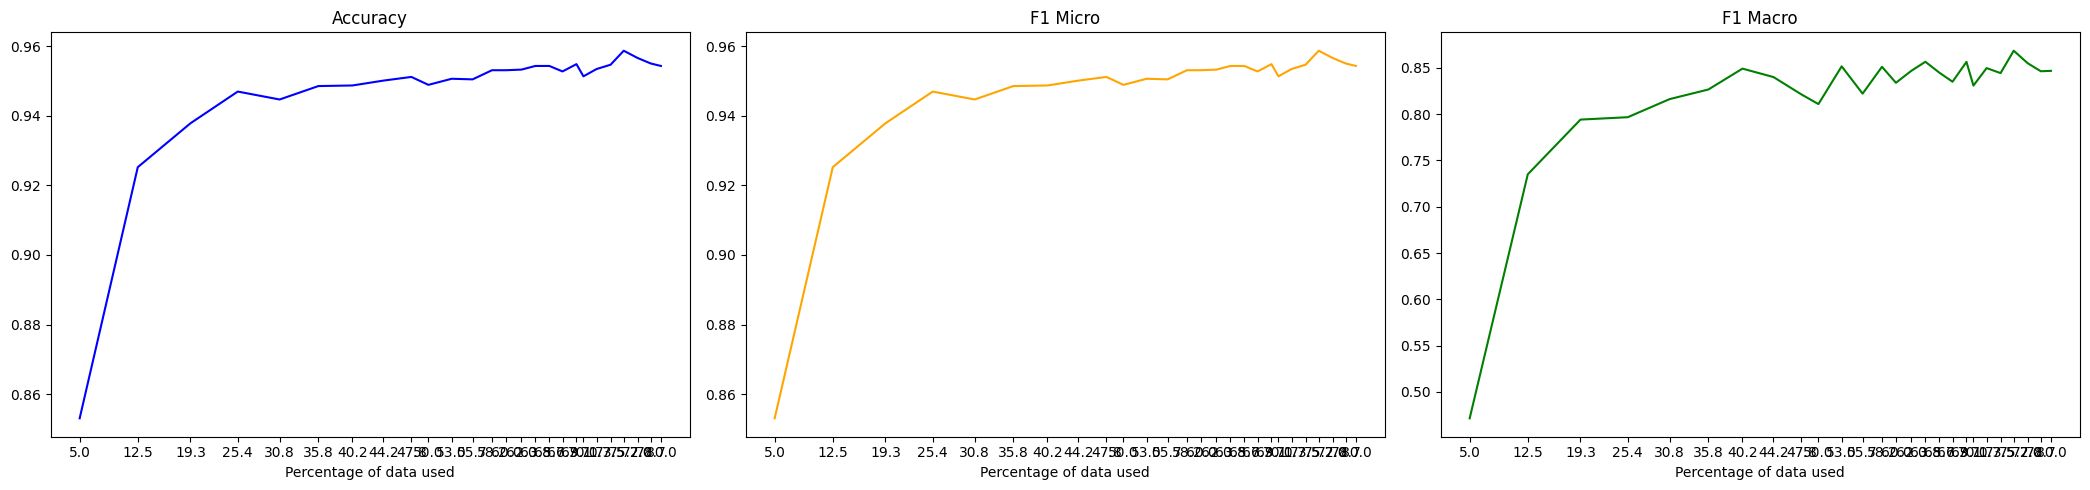

In [30]:
active_learning(seeds[4], 4)